C:\Users\fabio\AppData\Local\Temp\ipykernel_7432\2668881700.py:682: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Ajustar para acomodar título e rodapé
C:\Users\fabio\AppData\Local\Temp\ipykernel_7432\2668881700.py:1654: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\fabio\AppData\Local\Temp\ipykernel_7432\2668881700.py:1397: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\fabio\AppData\Local\Temp\ipykernel_7432\2668881700.py:1747: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\fabio\AppData\Local\Temp\ipykernel_7432\2668881700.py:2587: UserWarning: This figure includes Axes that are not comp

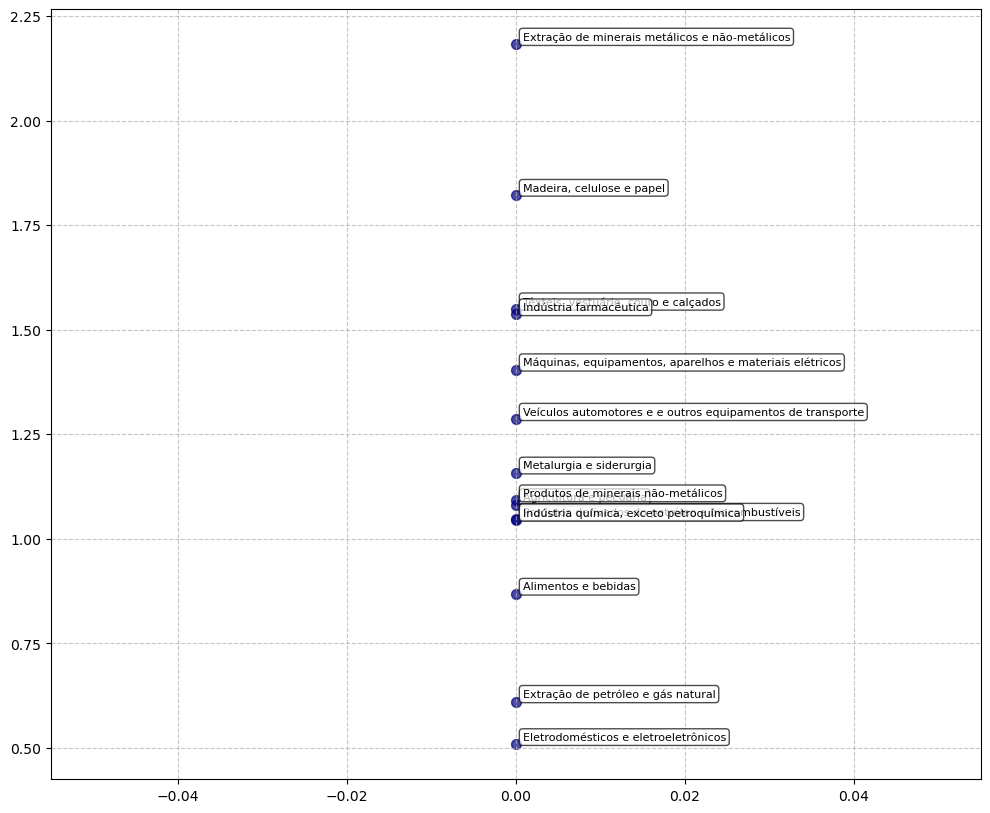

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import traceback
from typing import Dict, List, Optional, Tuple
import logging
import yaml
import sys
import time
from datetime import datetime


        
class PlotEstimationModel:
    
    def __init__(self, estimation_dir: Path, output_dir: Path, logger: Optional[logging.Logger] = None):
        self._validate_directories(estimation_dir, output_dir)
        self.estimation_dir = estimation_dir
        self.output_dir = output_dir
        self.logger = logger or self._setup_default_logger()
        self._setup_plot_style()
    
    def _validate_directories(self, estimation_dir: Path, output_dir: Path):
        if not estimation_dir.exists():
            raise FileNotFoundError(f"Estimation directory not found: {estimation_dir}")
        output_dir.mkdir(parents=True, exist_ok=True)
    
    def load_data(self):
        """
        Unified method to load and validate all estimation result files.
        """
        try:
            # Define expected files and their validation schemas
            data_files = {
                'productivity_firm': {
                    'filename': 'produtividade_empresa.xlsx',
                    'required_columns': ['setor_codigo', 'setor_nome', 'empresa', 
                                       'ano', 'trimestre', 'produtividade']
                },
                'productivity_summary': {
                    'filename': 'produtividade_sumario.xlsx',
                    'required_columns': ['setor_codigo', 'setor_nome', 'mean', 'std', 
                                       'median', 'min', 'max', 'q25', 'q75']
                },
                'markup_summary': {
                    'filename': 'markup_sumario.xlsx',
                    'required_columns': ['setor_codigo', 'setor_nome', 'mean', 'std',
                                       'median', 'min', 'max', 'q25', 'q75']
                },
                'markup_firm': {
                    'filename': 'markups_empresa.xlsx',
                    'required_columns': ['setor_codigo', 'setor_nome', 'empresa', 
                                       'ano', 'trimestre', 'markup']
                },
                'diagnostics': {
                    'filename': 'diagnosticos.xlsx',
                    'required_columns': ['setor_codigo', 'setor_nome', 'first_stage_r2',
                                       'variable_input_elasticity', 'capital_elasticity'] # Adicionadas as elasticidades
                }
            }
    
            loaded_data = {}
    
            for key, file_info in data_files.items():
                file_path = self.estimation_dir / file_info['filename']
    
                if not file_path.exists():
                    if key == 'markup_summary':  # Tornar opcional por enquanto
                        self.logger.warning(f"Arquivo {file_info['filename']} não encontrado. Continuando sem ele.")
                        continue
                    else:
                        raise FileNotFoundError(f"Required file not found: {file_info['filename']}")
    
                # Load data with robust error handling
                try:
                    df = pd.read_excel(file_path, dtype_backend='pyarrow')
    
                    # Validate columns
                    missing_cols = set(file_info['required_columns']) - set(df.columns)
                    if missing_cols:
                        raise ValueError(f"Missing required columns in {file_info['filename']}: {missing_cols}")
    
                    # Basic data validation
                    if df.empty:
                        raise ValueError(f"Empty dataset in {file_info['filename']}")
    
                    # Store validated data
                    loaded_data[key] = df
                    self.logger.info(f"Successfully loaded {file_info['filename']}")
    
                except Exception as e:
                    self.logger.error(f"Error loading {file_info['filename']}: {str(e)}")
                    raise
    
            return loaded_data
        
        except Exception as e:
            self.logger.error(f"Failed to load estimation data: {str(e)}")
            raise
                
    def prepare_data(self, loaded_data: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
        """
        Prepara e organiza os dados para plotagem mantendo a estrutura temporal/agregada.
        Incorpora dados de resumo (summaries) no DataFrame agregado.
    
        Args:
            loaded_data: Dicionário com DataFrames carregados
    
        Returns:
            Dict contendo:
                - 'temporal': DataFrame com dados em nível empresa-tempo (markup e produtividade)
                - 'agregado': DataFrame com dados em nível setor (elasticidades, diagnósticos e summaries)
        """
        try:
            # 1. Preparar dados temporais (nível empresa-tempo)
            df_markup = loaded_data['markup_firm']
            df_prod = loaded_data['productivity_firm']
    
            # Converter códigos para string
            df_markup['setor_codigo'] = df_markup['setor_codigo'].astype(str)
            df_prod['setor_codigo'] = df_prod['setor_codigo'].astype(str)
    
            # Merge dados temporais
            df_temporal = pd.merge(
                df_markup,
                df_prod[['setor_codigo', 'empresa', 'ano', 'trimestre', 'produtividade']],
                on=['setor_codigo', 'empresa', 'ano', 'trimestre']
            )
    
            # Remover outliers dos dados temporais
            df_temporal = self._remove_outliers(df_temporal, 
                                              columns=['markup', 'produtividade'],
                                              n_std=3)
    
            # 2. Preparar dados agregados, começando pelos diagnósticos
            df_agregado = loaded_data['diagnostics'].copy()
            df_agregado['setor_codigo'] = df_agregado['setor_codigo'].astype(str)
            
            # 3. Incorporar dados de resumo (summaries) no DataFrame agregado
            
            # Adicionar resumo de produtividade
            if 'productivity_summary' in loaded_data:
                prod_summary = loaded_data['productivity_summary']
                prod_summary['setor_codigo'] = prod_summary['setor_codigo'].astype(str)
                
                # Renomear colunas para evitar colisões e identificar a origem
                prod_cols = {col: f'prod_{col}' for col in prod_summary.columns 
                           if col not in ['setor_codigo', 'setor_nome']}
                prod_summary = prod_summary.rename(columns=prod_cols)
                
                # Merge com df_agregado
                df_agregado = pd.merge(
                    df_agregado, 
                    prod_summary,
                    on=['setor_codigo', 'setor_nome'],
                    how='left'
                )
                
            # Adicionar resumo de markup se disponível
            if 'markup_summary' in loaded_data:
                markup_summary = loaded_data['markup_summary']
                markup_summary['setor_codigo'] = markup_summary['setor_codigo'].astype(str)
                
                # Renomear colunas para evitar colisões e identificar a origem
                markup_cols = {col: f'markup_{col}' for col in markup_summary.columns 
                            if col not in ['setor_codigo', 'setor_nome']}
                markup_summary = markup_summary.rename(columns=markup_cols)
                
                # Merge com df_agregado
                df_agregado = pd.merge(
                    df_agregado, 
                    markup_summary,
                    on=['setor_codigo', 'setor_nome'],
                    how='left'
                )
    
            # Retornar dicionário com os dois tipos de dados originais
            prepared_data = {
                'temporal': df_temporal,
                'agregado': df_agregado
            }
    
            return prepared_data
    
        except Exception as e:
            self.logger.error(f"Erro na preparação dos dados: {str(e)}")
            raise
    """        
    def run_analysis(self):
        Executa todo o pipeline de análise
        try:
            # Carregar dados
            loaded_data = self.load_data()

            # Preparar dados organizando em temporal e agregado
            prepared_data = self.prepare_data(loaded_data)

            # Gerar visualizações da função de produção
            self._plot_production_function(prepared_data['agregado'], self.output_dir)

            # Gerar visualizações de produtividade
            self._plot_productivity_evolution(prepared_data['temporal'], self.output_dir)

            # Gerar visualizações de markup
            self._plot_markup_evolution(prepared_data['temporal'], self.output_dir)

            # Gerar visualizações estáticas de markup (agora separadas)
            self._plot_markup_distribution_fig(prepared_data['temporal'], self.output_dir)
            self._plot_sectoral_means_fig(prepared_data['temporal'], self.output_dir)
            self._plot_sectoral_distribution_fig(prepared_data['temporal'], self.output_dir)
            self._plot_markup_observations_fig(prepared_data['temporal'], self.output_dir)

            # Gerar decomposição de markup
            self._plot_markup_decomposition(prepared_data['temporal'], self.output_dir)

            # Gerar relação markup-produtividade
            self._plot_markup_productivity(prepared_data['temporal'], self.output_dir)

            self.logger.info("Análise completa gerada com sucesso")

        except Exception as e:
            self.logger.error(f"Erro na execução da análise: {str(e)}")
            raise
    """

    def run_analysis(self):
        """Executa todo o pipeline de análise"""
        try:
            # Carregar dados
            loaded_data = self.load_data()
    
            # Preparar dados organizando em temporal e agregado
            prepared_data = self.prepare_data(loaded_data)
            
            # Exportar dados calculados
            self.export_calculated_data(prepared_data, self.output_dir)
    
            # Gerar visualizações da função de produção
            self._plot_production_function(prepared_data['agregado'], self.output_dir)
    
            # Gerar visualizações de produtividade
            self._plot_productivity_evolution(prepared_data['temporal'], self.output_dir)
    
            # Gerar visualizações de markup
            self._plot_markup_evolution(prepared_data['temporal'], self.output_dir)
    
            # Gerar visualizações estáticas de markup (agora separadas)
            self._plot_markup_distribution_fig(prepared_data['temporal'], self.output_dir)
            self._plot_sectoral_means_fig(prepared_data['temporal'], self.output_dir)
            self._plot_sectoral_distribution_fig(prepared_data['temporal'], self.output_dir)
            self._plot_markup_observations_fig(prepared_data['temporal'], self.output_dir)
    
            # Gerar decomposição de markup
            self._plot_markup_decomposition(prepared_data['temporal'], self.output_dir)
    
            # Gerar relação markup-produtividade
            self._plot_markup_productivity(prepared_data['temporal'], self.output_dir)
            
            # Novo: Gerar comparação dos resumos se as colunas existirem no agregado
            has_markup_summary = any(col.startswith('markup_') for col in prepared_data['agregado'].columns)
            has_prod_summary = any(col.startswith('prod_') for col in prepared_data['agregado'].columns)
            
            if has_markup_summary and has_prod_summary:
                self._plot_summary_comparison(prepared_data['agregado'], self.output_dir)
    
            self.logger.info("Análise completa gerada com sucesso")
    
        except Exception as e:
            self.logger.error(f"Erro na execução da análise: {str(e)}")
            raise

    def generate_all_plots(self, prepared_data: Dict[str, pd.DataFrame], output_dir: Path):
        """
        Método principal para gerar todos os grupos de gráficos

        Args:
            prepared_data: Dicionário com DataFrames preparados ('temporal' e 'agregado')
            output_dir: Diretório para salvar as visualizações
        """
        try:
            # Função de produção
            self._plot_production_function(prepared_data['agregado'], output_dir)
            self.logger.info("Gráficos de função de produção gerados")

            # Produtividade
            self._plot_productivity_evolution(prepared_data['temporal'], output_dir)
            self.logger.info("Gráficos de evolução da produtividade gerados")

            # Evolução do markup
            self._plot_markup_evolution(prepared_data['temporal'], output_dir)
            self.logger.info("Gráficos de evolução do markup gerados")

            # Análise estática do markup
            self._plot_markup_distribution_fig(prepared_data['temporal'], output_dir)
            self._plot_sectoral_means_fig(prepared_data['temporal'], output_dir)
            self._plot_sectoral_distribution_fig(prepared_data['temporal'], output_dir)
            self._plot_markup_observations_fig(prepared_data['temporal'], output_dir)
            self.logger.info("Gráficos de análise estática do markup gerados")

            # Decomposição do markup
            self._plot_markup_decomposition(prepared_data['temporal'], output_dir)
            self.logger.info("Gráficos de decomposição do markup gerados")

            # Relação markup-produtividade
            self._plot_markup_productivity(prepared_data['temporal'], output_dir)
            self.logger.info("Gráficos de relação markup-produtividade gerados")

            # Verificar se temos dados de resumo disponíveis no DataFrame agregado
            has_markup_summary = any(col.startswith('markup_') for col in prepared_data['agregado'].columns)
            has_prod_summary = any(col.startswith('prod_') for col in prepared_data['agregado'].columns)
        
            if has_markup_summary and has_prod_summary:
                self._plot_summary_comparison(prepared_data['agregado'], output_dir)
                self.logger.info("Gráficos de comparação dos resumos gerados")
        
        except Exception as e:
            self.logger.error(f"Erro na geração dos gráficos: {str(e)}")
            traceback.print_exc()            

    def _validate_data(self, df: pd.DataFrame, required_cols: List[str]) -> bool:
        """Validação básica dos dados"""
        missing_cols = set(required_cols) - set(df.columns)
        if missing_cols:
            raise ValueError(f"Colunas ausentes: {missing_cols}")
        return True                

    def _setup_plot_style(self):
        """Configura estilo padrão dos gráficos"""
        # Usar estilo padrão
        plt.style.use('default')

        # Configurar parâmetros
        plt.rcParams.update({
            'figure.figsize': (12, 8),
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 10,
            'axes.grid': True,
            'grid.alpha': 0.7,
            'grid.linestyle': '--'
        })
    
    def _remove_outliers(self, df: pd.DataFrame, columns: List[str], 
                        n_std: float = 3) -> pd.DataFrame:
        """Remove outliers usando desvio padrão"""
        df_clean = df.copy()
        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df_clean = df_clean[
                (df_clean[col] > mean - n_std * std) & 
                (df_clean[col] < mean + n_std * std)
            ]
        return df_clean

    def _setup_file_logger(self):
        """Configura logger com arquivo"""
        log_file = self.output_dir / 'analysis.log'
        handler = logging.FileHandler(log_file)
        handler.setFormatter(
            logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        )
        self.logger.addHandler(handler)

    def _setup_default_logger(self):
        logger = logging.getLogger('PlotEstimationModel')
        logger.setLevel(logging.INFO)
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s: %(message)s'))
        logger.addHandler(console_handler)
        return logger
  
    def _filter_time_series(self, df: pd.DataFrame, min_obs: int = 15) -> pd.DataFrame:
        """
        Filtra períodos com número mínimo de observações

        Args:
            df: DataFrame com dados temporais
            min_obs: Número mínimo de observações por período

        Returns:
            DataFrame apenas com períodos que têm observações suficientes
        """
        period_counts = df.groupby(['ano', 'trimestre']).size()
        valid_periods = period_counts[period_counts >= min_obs].index

        return df[df.set_index(['ano', 'trimestre']).index.isin(valid_periods)]

    """
    def _plot_production_function(self, df_agregado, output_dir):
        Production function estimation diagnostics
        try:
            fig = plt.figure(figsize=(15, 15))
            gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

            # Panel A: Parameter Estimates
            ax1 = fig.add_subplot(gs[0, 0])
            self._plot_parameter_estimates(ax1, df_agregado)
            ax1.set_title('Elasticidades da Função de Produção', pad=20, fontsize=14)

            # Panel B: Returns to Scale
            ax2 = fig.add_subplot(gs[0, 1])
            self._plot_returns_scale(ax2, df_agregado)
            ax2.set_title('Retornos à Escala por Setor', pad=20, fontsize=14)

            # Panel C: First Stage R²
            ax3 = fig.add_subplot(gs[1, 0])
            self._plot_r2_distribution(ax3, df_agregado)
            ax3.set_title('Distribuição do R² - Primeiro Estágio', pad=20, fontsize=14)

            # Panel D: Model Fit Statistics
            ax4 = fig.add_subplot(gs[1, 1])
            self._plot_model_fit(ax4, df_agregado)
            ax4.set_title('Ajuste do Modelo por Setor', pad=20, fontsize=14)

            plt.tight_layout()
            plt.savefig(output_dir / 'production_function_diagnostics.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in production function plots: {str(e)}")
            traceback.print_exc()

    def _plot_parameter_estimates(self, ax, df_agregado):
        Plot parameter estimates with confidence intervals
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de elasticidades disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Extrair setores e elasticidades
            sectors = df_agregado['setor_nome'].tolist()
            var_input = df_agregado['variable_input'].tolist()
            capital = df_agregado['capital'].tolist()

            # Verificar se há dados para plotar
            if not sectors or not var_input or not capital:
                ax.text(0.5, 0.5, 'Dados insuficientes para parâmetros',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Criar posições para as barras
            x = np.arange(len(sectors))
            width = 0.35

            # Plotar barras
            ax.bar(x - width/2, var_input, width, 
                   label='Insumo Variável', color='#4472C4', alpha=0.8)
            ax.bar(x + width/2, capital, width, 
                   label='Capital', color='#ED7D31', alpha=0.8)

            # Formatação
            ax.set_xticks(x)
            ax.set_xticklabels(sectors, rotation=45, ha='right', fontsize=9)
            ax.set_ylabel('Elasticidade', fontsize=12)
            ax.legend(fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)

            # Linha horizontal em 0
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

            # Ajustar limites do eixo y
            ymin = min(min(var_input or [0]), min(capital or [0]))
            ymax = max(max(var_input or [0]), max(capital or [0]))
            margin = max(0.1, (ymax - ymin) * 0.1)
            ax.set_ylim(ymin - margin, ymax + margin)

        except Exception as e:
            self.logger.error(f"Error in parameter estimates plot: {str(e)}")

    def _plot_returns_scale(self, ax, df_agregado):
        Plot retornos à escala por setor
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de retornos à escala disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Calcular retornos à escala = soma das elasticidades
            df_agregado['rts'] = df_agregado['variable_input'] + df_agregado['capital']

            # Ordenar por retornos
            df_sorted = df_agregado.sort_values('rts')
            sectors = df_sorted['setor_nome'].tolist()
            rts_values = df_sorted['rts'].tolist()

            # Verificar se há dados para plotar
            if not sectors or not rts_values:
                ax.text(0.5, 0.5, 'Dados insuficientes para retornos à escala',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Criar posições para barras
            y_pos = np.arange(len(sectors))

            # Plotar barras horizontais
            colors = ['#4472C4' if r >= 1 else '#ED7D31' for r in rts_values]
            bars = ax.barh(y_pos, rts_values, color=colors, alpha=0.8)

            # Adicionar linha para retornos constantes
            ax.axvline(x=1, color='red', linestyle='--', alpha=0.7, 
                      label='Retornos Constantes')

            # Adicionar valores nas barras
            for i, v in enumerate(rts_values):
                ax.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=9)

            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(sectors, fontsize=9)
            ax.set_xlabel('Retornos à Escala', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(fontsize=10)

        except Exception as e:
            self.logger.error(f"Error in returns to scale plot: {str(e)}")

    def _plot_r2_distribution(self, ax, df_agregado):
        Plot distribuição do R2 do primeiro estágio
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0 or 'first_stage_r2' not in df_agregado.columns:
                ax.text(0.5, 0.5, 'Sem dados de R² disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Extrair valores de R²
            r2_values = df_agregado['first_stage_r2'].dropna().tolist()

            # Verificar se há dados para plotar
            if not r2_values:
                ax.text(0.5, 0.5, 'Dados insuficientes para R²',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Histograma
            n, bins, patches = ax.hist(r2_values, bins=10, color='#4472C4', alpha=0.8,
                                     edgecolor='black')

            # Estatísticas descritivas
            mean_r2 = np.mean(r2_values)
            median_r2 = np.median(r2_values)

            # Adicionar linha para média e mediana
            ax.axvline(x=mean_r2, color='red', linestyle='-', alpha=0.8, linewidth=2,
                      label=f'Média: {mean_r2:.3f}')
            ax.axvline(x=median_r2, color='green', linestyle='--', alpha=0.8, linewidth=2,
                      label=f'Mediana: {median_r2:.3f}')

            # Adicionar estatísticas
            stats_text = (
                f"Média: {mean_r2:.3f}\n"
                f"Mediana: {median_r2:.3f}\n"
                f"Min: {min(r2_values):.3f}\n"
                f"Max: {max(r2_values):.3f}\n"
                f"N: {len(r2_values)}"
            )
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                   va='top', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

            # Formatação
            ax.set_xlabel('R² Primeiro Estágio', fontsize=12)
            ax.set_ylabel('Número de Setores', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(fontsize=10)

        except Exception as e:
            self.logger.error(f"Error in R² distribution plot: {str(e)}")

    def _plot_model_fit(self, ax, df_agregado):
        Plot estatísticas de ajuste por setor
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0 or 'first_stage_r2' not in df_agregado.columns:
                ax.text(0.5, 0.5, 'Sem dados de ajuste do modelo disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Filtrar setores com dados completos
            mask = df_agregado['first_stage_r2'].notna()
            if 'second_stage_r2' in df_agregado.columns:
                mask = mask & df_agregado['second_stage_r2'].notna()

            df_filtered = df_agregado[mask]

            # Verificar se há dados para plotar
            if len(df_filtered) == 0:
                ax.text(0.5, 0.5, 'Dados insuficientes para ajuste do modelo',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Ordenar por R² do primeiro estágio
            df_sorted = df_filtered.sort_values('first_stage_r2')
            sectors = df_sorted['setor_nome'].tolist()
            r2_first = df_sorted['first_stage_r2'].tolist()

            # R² do segundo estágio se disponível
            if 'second_stage_r2' in df_filtered.columns:
                r2_second = df_sorted['second_stage_r2'].tolist()
            else:
                r2_second = None

            # Criar posições para as barras
            y_pos = np.arange(len(sectors))
            width = 0.35

            # Plotar R² do primeiro estágio
            ax.barh(y_pos, r2_first, height=width, color='#4472C4', alpha=0.8,
                   label='R² 1º Estágio')

            # Plotar R² do segundo estágio se disponível
            if r2_second:
                ax.barh(y_pos + width, r2_second, height=width, color='#ED7D31', alpha=0.8,
                       label='R² 2º Estágio')

            # Formatação
            ax.set_yticks(y_pos + (width/2 if r2_second else 0))
            ax.set_yticklabels(sectors, fontsize=9)
            ax.set_xlabel('R²', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(fontsize=10)

            # Ajustar limites
            ax.set_xlim(0, 1.05)

        except Exception as e:
            self.logger.error(f"Error in model fit plot: {str(e)}")   
    """            

    def _plot_production_function(self, df_agregado, output_dir):
        """
        Produz um painel de diagnósticos aprimorados da função de produção
        com layout otimizado e elementos visuais melhorados.
        """
        try:
            # Criar figura com melhor proporção para acomodar gráficos horizontais
            fig = plt.figure(figsize=(15, 16))

            # Criar grid com mais espaço entre subplots
            gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

            # Reordenar os painéis para contar uma narrativa mais coerente
            # Painel 1: Ajuste do Modelo (R² por setor)
            ax1 = fig.add_subplot(gs[0, 0])
            self._plot_model_fit_improved(ax1, df_agregado)
            ax1.set_title('Qualidade do Ajuste por Setor', pad=20, fontsize=14)

            # Painel 2: Distribuição do R2
            ax2 = fig.add_subplot(gs[0, 1])
            self._plot_r2_distribution_improved(ax2, df_agregado)
            ax2.set_title('Distribuição do R2 do Primeiro Estágio', pad=20, fontsize=14)

            # Painel 3: Elasticidades da função de produção
            ax3 = fig.add_subplot(gs[1, 0])
            self._plot_parameter_estimates_improved(ax3, df_agregado)
            ax3.set_title('Elasticidades Estimadas da Função de Produção', pad=20, fontsize=14)

            # Painel 4: Retornos à escala
            ax4 = fig.add_subplot(gs[1, 1])
            self._plot_returns_scale_improved(ax4, df_agregado)
            ax4.set_title('Retornos à Escala por Setor', pad=20, fontsize=14)

            # Adicionar título geral
            fig.suptitle('Diagnósticos da Estimação da Função de Produção', 
                        fontsize=16, y=0.99, fontweight='bold')

            # Adicionar nota de rodapé com interpretação
            fig.text(0.5, 0.01, 
                    'Interpretação: Elasticidades positivas indicam relação direta entre insumo e produto.\n'
                    'Retornos à escala > 1 indicam que aumentos proporcionais nos insumos geram aumentos mais que proporcionais no produto.',
                    ha='center', fontsize=10, fontfamily='sans-serif', 
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

            plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Ajustar para acomodar título e rodapé
            plt.savefig(output_dir / 'production_function_diagnostics_improved.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in improved production function plots: {str(e)}")
            traceback.print_exc()
    """
    def _plot_parameter_estimates_improved(self, ax, df_agregado):
        
        Versão aprimorada do gráfico de elasticidades da função de produção,
        com ordenação, melhor legibilidade e anotações contextuais.
        
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de elasticidades disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Calcular elasticidades totais (retornos à escala)
            df_agregado = df_agregado.copy()
            df_agregado['rts'] = df_agregado['variable_input'] + df_agregado['capital']

            # Ordenar por elasticidade do insumo variável
            df_sorted = df_agregado.sort_values('variable_input', ascending=True)

            # Extrair dados
            sectors = df_sorted['setor_nome'].tolist()
            var_input = df_sorted['variable_input'].tolist()
            capital = df_sorted['capital'].tolist()

            # Abreviar nomes longos dos setores para melhor legibilidade
            short_sectors = []
            for sector in sectors:
                if len(sector) > 25:
                    words = sector.split()
                    if len(words) > 3:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = sector[:22] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(sector)

            # Criar posições para as barras
            y_pos = np.arange(len(short_sectors))
            height = 0.35

            # Definir esquema de cores acessível para daltônicos
            color_insumo = '#1f77b4'  # Azul mais intenso
            color_capital = '#ff7f0e'  # Laranja mais intenso

            # Plotar barras horizontais
            ax.barh(y_pos - height/2, var_input, height, 
                   label='Insumo Variável', color=color_insumo, alpha=0.8)
            ax.barh(y_pos + height/2, capital, height, 
                   label='Capital', color=color_capital, alpha=0.8)

            # Adicionar linha vertical em 0 para referência
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

            # Adicionar anotações para valores negativos significativos
            for i, (vi, k) in enumerate(zip(var_input, capital)):
                if k < -0.2:  # Valores negativos significativos de capital
                    ax.annotate('*', (k - 0.05, y_pos[i] + height/2), 
                               color='red', fontsize=12, fontweight='bold')

            # Adicionar texto explicativo sobre elasticidades negativas
            negatives_exist = any(k < 0 for k in capital)
            if negatives_exist:
                ax.text(0.01, 0.01, 
                       '* Elasticidades negativas do capital podem indicar\n'
                       '  sobre-investimento ou tecnologias obsoletas.',
                       transform=ax.transAxes, fontsize=9, va='bottom',
                       bbox=dict(facecolor='white', alpha=0.8))

            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(short_sectors, fontsize=10)
            ax.set_xlabel('Elasticidade', fontsize=12)

            # Melhorar legenda
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=2, frameon=True, fontsize=10)

            # Grid apenas no eixo horizontal
            ax.grid(True, axis='x', linestyle='--', alpha=0.6)

            # Adicionar anotação com interpretação direta
            ax.text(0.98, 0.98, 
                   'Interpretação:\n'
                   'Valores representam o aumento\n'
                   'percentual no produto para\n'
                   'cada 1% de aumento no insumo',
                   transform=ax.transAxes, fontsize=9, ha='right', va='top',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

        except Exception as e:
            self.logger.error(f"Error in improved parameter estimates plot: {str(e)}")
    """
    def _plot_parameter_estimates_improved(self, ax, df_agregado):
        """
        Versão aprimorada do gráfico de elasticidades da função de produção,
        com ordenação, melhor legibilidade e anotações contextuais.
        """
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de elasticidades disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return
    
            # Criar uma cópia para não modificar o original
            df_work = df_agregado.copy()
            
            # Verificar quais colunas de elasticidades estão disponíveis
            elasticity_columns = {
                'variable_input_elasticity': 'variable_input',
                'capital_elasticity': 'capital'
            }
            
            # Mapeamento de colunas
            for col_original, col_expected in elasticity_columns.items():
                if col_original in df_work.columns and col_expected not in df_work.columns:
                    df_work[col_expected] = df_work[col_original]
            
            # Verificar se após o mapeamento temos as colunas necessárias
            if 'variable_input' not in df_work.columns or 'capital' not in df_work.columns:
                ax.text(0.5, 0.5, 'Colunas de elasticidades não encontradas nos diagnósticos',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return
    
            # Calcular elasticidades totais (retornos à escala)
            df_work['rts'] = df_work['variable_input'] + df_work['capital']
    
            # Ordenar por elasticidade do insumo variável
            df_sorted = df_work.sort_values('variable_input', ascending=True)
    
            # Extrair dados
            sectors = df_sorted['setor_nome'].tolist()
            var_input = df_sorted['variable_input'].tolist()
            capital = df_sorted['capital'].tolist()
    
            # Verificar se há dados para plotar
            if not sectors or not var_input or not capital:
                ax.text(0.5, 0.5, 'Dados insuficientes para plotar elasticidades',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return
    
            # Abreviar nomes longos dos setores para melhor legibilidade
            short_sectors = []
            for sector in sectors:
                if len(sector) > 25:
                    words = sector.split()
                    if len(words) > 3:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = sector[:22] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(sector)
    
            # Criar posições para as barras
            y_pos = np.arange(len(short_sectors))
            height = 0.35
    
            # Definir esquema de cores acessível para daltônicos
            color_insumo = '#1f77b4'  # Azul mais intenso
            color_capital = '#ff7f0e'  # Laranja mais intenso
    
            # Plotar barras horizontais
            ax.barh(y_pos - height/2, var_input, height, 
                   label='Insumo Variável', color=color_insumo, alpha=0.8)
            ax.barh(y_pos + height/2, capital, height, 
                   label='Capital', color=color_capital, alpha=0.8)
    
            # Adicionar linha vertical em 0 para referência
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    
            # Adicionar anotações para valores negativos significativos
            for i, (vi, k) in enumerate(zip(var_input, capital)):
                if k < -0.2:  # Valores negativos significativos de capital
                    ax.annotate('*', (k - 0.05, y_pos[i] + height/2), 
                               color='red', fontsize=12, fontweight='bold')
    
            # Adicionar texto explicativo sobre elasticidades negativas
            negatives_exist = any(k < 0 for k in capital)
            if negatives_exist:
                ax.text(0.01, 0.01, 
                       '* Elasticidades negativas do capital podem indicar\n'
                       '  sobre-investimento ou tecnologias obsoletas.',
                       transform=ax.transAxes, fontsize=9, va='bottom',
                       bbox=dict(facecolor='white', alpha=0.8))
    
            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(short_sectors, fontsize=10)
            ax.set_xlabel('Elasticidade', fontsize=12)
    
            # Melhorar legenda
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=2, frameon=True, fontsize=10)
    
            # Grid apenas no eixo horizontal
            ax.grid(True, axis='x', linestyle='--', alpha=0.6)
    
            # Adicionar anotação com interpretação direta
            ax.text(0.98, 0.98, 
                   'Interpretação:\n'
                   'Valores representam o aumento\n'
                   'percentual no produto para\n'
                   'cada 1% de aumento no insumo',
                   transform=ax.transAxes, fontsize=9, ha='right', va='top',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
        except Exception as e:
            self.logger.error(f"Error in improved parameter estimates plot: {str(e)}")
            traceback.print_exc()
    """
    def _plot_returns_scale_improved(self, ax, df_agregado):
        
        Versão aprimorada do gráfico de retornos à escala, com melhores
        elementos visuais, ordenação e anotações contextuais.
        
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de retornos à escala disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Calcular retornos à escala = soma das elasticidades
            df_agregado = df_agregado.copy()
            df_agregado['rts'] = df_agregado['variable_input'] + df_agregado['capital']

            # Ordenar por retornos
            df_sorted = df_agregado.sort_values('rts', ascending=True)
            sectors = df_sorted['setor_nome'].tolist()
            rts_values = df_sorted['rts'].tolist()

            # Abreviar nomes longos
            short_sectors = []
            for sector in sectors:
                if len(sector) > 25:
                    words = sector.split()
                    if len(words) > 3:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = sector[:22] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(sector)

            # Criar posições para barras
            y_pos = np.arange(len(short_sectors))

            # Definir esquema de cores mais semântico e acessível
            colors = []
            for r in rts_values:
                if r > 1.05:  # Retornos claramente crescentes
                    colors.append('#1a9850')  # Verde mais intenso
                elif r < 0.95:  # Retornos claramente decrescentes
                    colors.append('#d73027')  # Vermelho mais intenso
                else:  # Retornos aproximadamente constantes
                    colors.append('#4575b4')  # Azul

            # Plotar barras horizontais
            bars = ax.barh(y_pos, rts_values, color=colors, alpha=0.8, height=0.6)

            # Adicionar linha para retornos constantes
            ax.axvline(x=1, color='red', linestyle='--', alpha=0.7,
                      label='Retornos Constantes')

            # Adicionar valores nas barras
            for i, v in enumerate(rts_values):
                # Escolher posição e cor do texto com base no valor
                if v > 1.4:
                    x_pos = v - 0.1
                    ha = 'right'
                    color = 'white'
                elif v < 0.7:
                    x_pos = v + 0.05
                    ha = 'left'
                    color = 'black'
                else:
                    x_pos = v + 0.02
                    ha = 'left'
                    color = 'black'

                ax.text(x_pos, i, f"{v:.2f}", va='center', fontsize=10, 
                       fontweight='bold', color=color, ha=ha)

            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(short_sectors, fontsize=10)
            ax.set_xlabel('Retornos à Escala', fontsize=12)
            ax.grid(True, axis='x', linestyle='--', alpha=0.6)

            # Melhorar legenda
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=1, frameon=True, fontsize=10)

            # Adicionar anotações para principais grupos
            x_min, x_max = ax.get_xlim()
            ax.annotate('Retornos\nDecrescentes', xy=(0.9, 0.05), xycoords='axes fraction',
                       ha='center', fontsize=9, bbox=dict(facecolor='#ffcccc', alpha=0.7))
            ax.annotate('Retornos\nCrescentes', xy=(1.1, 0.05), xycoords='axes fraction',
                       ha='center', fontsize=9, bbox=dict(facecolor='#ccffcc', alpha=0.7))

            # Adicionar explicação
            ax.text(0.98, 0.98, 
                   'Interpretação:\n'
                   '> 1: Retornos crescentes à escala\n'
                   '= 1: Retornos constantes à escala\n'
                   '< 1: Retornos decrescentes à escala',
                   transform=ax.transAxes, fontsize=9, ha='right', va='top',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

        except Exception as e:
            self.logger.error(f"Error in improved returns to scale plot: {str(e)}")
    """

    def _plot_returns_scale_improved(self, ax, df_agregado):
        """
        Versão aprimorada do gráfico de retornos à escala, com melhores
        elementos visuais, ordenação e anotações contextuais.
        """
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0:
                ax.text(0.5, 0.5, 'Sem dados de retornos à escala disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return
    
            # Criar uma cópia para não modificar o original
            df_work = df_agregado.copy()
            
            # Verificar quais colunas de elasticidades estão disponíveis
            elasticity_columns = {
                'variable_input_elasticity': 'variable_input',
                'capital_elasticity': 'capital'
            }
            
            # Mapeamento de colunas
            for col_original, col_expected in elasticity_columns.items():
                if col_original in df_work.columns and col_expected not in df_work.columns:
                    df_work[col_expected] = df_work[col_original]
            
            # Verificar se após o mapeamento temos as colunas necessárias
            if 'variable_input' not in df_work.columns or 'capital' not in df_work.columns:
                ax.text(0.5, 0.5, 'Colunas de elasticidades não encontradas nos diagnósticos',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return
    
            # Calcular retornos à escala = soma das elasticidades
            df_work['rts'] = df_work['variable_input'] + df_work['capital']
    
            # Ordenar por retornos
            df_sorted = df_work.sort_values('rts', ascending=True)
            sectors = df_sorted['setor_nome'].tolist()
            rts_values = df_sorted['rts'].tolist()
    
            # Abreviar nomes longos
            short_sectors = []
            for sector in sectors:
                if len(sector) > 25:
                    words = sector.split()
                    if len(words) > 3:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = sector[:22] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(sector)
    
            # Criar posições para barras
            y_pos = np.arange(len(short_sectors))
    
            # Definir esquema de cores mais semântico e acessível
            colors = []
            for r in rts_values:
                if r > 1.05:  # Retornos claramente crescentes
                    colors.append('#1a9850')  # Verde mais intenso
                elif r < 0.95:  # Retornos claramente decrescentes
                    colors.append('#d73027')  # Vermelho mais intenso
                else:  # Retornos aproximadamente constantes
                    colors.append('#4575b4')  # Azul
    
            # Plotar barras horizontais
            bars = ax.barh(y_pos, rts_values, color=colors, alpha=0.8, height=0.6)
    
            # Adicionar linha para retornos constantes
            ax.axvline(x=1, color='red', linestyle='--', alpha=0.7,
                      label='Retornos Constantes')
    
            # Adicionar valores nas barras
            for i, v in enumerate(rts_values):
                # Escolher posição e cor do texto com base no valor
                if v > 1.4:
                    x_pos = v - 0.1
                    ha = 'right'
                    color = 'white'
                elif v < 0.7:
                    x_pos = v + 0.05
                    ha = 'left'
                    color = 'black'
                else:
                    x_pos = v + 0.02
                    ha = 'left'
                    color = 'black'
    
                ax.text(x_pos, i, f"{v:.2f}", va='center', fontsize=10, 
                       fontweight='bold', color=color, ha=ha)
    
            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(short_sectors, fontsize=10)
            ax.set_xlabel('Retornos à Escala', fontsize=12)
            ax.grid(True, axis='x', linestyle='--', alpha=0.6)
    
            # Melhorar legenda
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=1, frameon=True, fontsize=10)
    
            # Adicionar anotações para principais grupos
            x_min, x_max = ax.get_xlim()
            ax.annotate('Retornos\nDecrescentes', xy=(0.9, 0.05), xycoords='axes fraction',
                       ha='center', fontsize=9, bbox=dict(facecolor='#ffcccc', alpha=0.7))
            ax.annotate('Retornos\nCrescentes', xy=(1.1, 0.05), xycoords='axes fraction',
                       ha='center', fontsize=9, bbox=dict(facecolor='#ccffcc', alpha=0.7))
    
            # Adicionar explicação
            ax.text(0.98, 0.98, 
                   'Interpretação:\n'
                   '> 1: Retornos crescentes à escala\n'
                   '= 1: Retornos constantes à escala\n'
                   '< 1: Retornos decrescentes à escala',
                   transform=ax.transAxes, fontsize=9, ha='right', va='top',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
        except Exception as e:
            self.logger.error(f"Error in improved returns to scale plot: {str(e)}")
            traceback.print_exc()
    
    def _plot_r2_distribution_improved(self, ax, df_agregado):
        """
        Versão aprimorada do gráfico de distribuição do R2 do primeiro estágio,
        com visualização aprimorada e melhor contexto interpretativo.
        """
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0 or 'first_stage_r2' not in df_agregado.columns:
                ax.text(0.5, 0.5, 'Sem dados de R2 disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Extrair valores de R²
            r2_values = df_agregado['first_stage_r2'].dropna().tolist()

            # Verificar se há dados para plotar
            if not r2_values:
                ax.text(0.5, 0.5, 'Dados insuficientes para R2',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Calcular estatísticas descritivas
            mean_r2 = np.mean(r2_values)
            median_r2 = np.median(r2_values)
            min_r2 = min(r2_values)
            max_r2 = max(r2_values)
            n = len(r2_values)

            # Para poucos pontos (n < 15), usar dotplot (stripplot) em vez de histograma
            if n < 15:
                # Plotar pontos individuais
                y_pos = [0.5] * n  # Todos na mesma linha horizontal
                sc = ax.scatter(r2_values, y_pos, s=100, alpha=0.7, 
                               color='#4472C4', edgecolor='black')

                # Adicionar rótulos com setores
                for i, r2 in enumerate(r2_values):
                    sector = df_agregado['first_stage_r2'].dropna().index[i]
                    try:
                        sector_name = df_agregado.loc[sector, 'setor_nome']
                        short_name = sector_name[:10] + '...' if len(sector_name) > 10 else sector_name
                        ax.annotate(short_name, (r2, 0.5), xytext=(0, -10),
                                   textcoords='offset points', ha='center', fontsize=8,
                                   rotation=45)
                    except:
                        pass
            else:
                # Para mais pontos, usar histograma otimizado
                # Determinar número ótimo de bins (regra de Sturges)
                n_bins = int(1 + 3.322 * np.log10(n))
                n_bins = min(max(5, n_bins), 10)  # Limitar entre 5 e 10 bins

                # Ajustar intervalo do histograma para focar na região relevante
                bin_range = (max(0.8, min_r2 - 0.05), min(1.0, max_r2 + 0.05))

                # Histograma
                n, bins, patches = ax.hist(r2_values, bins=n_bins, range=bin_range, 
                                         color='#4472C4', alpha=0.8, edgecolor='black')

            # Adicionar linha para média e mediana
            ax.axvline(x=mean_r2, color='red', linestyle='-', alpha=0.8, linewidth=2,
                      label=f'Média: {mean_r2:.3f}')
            ax.axvline(x=median_r2, color='green', linestyle='--', alpha=0.8, linewidth=2,
                      label=f'Mediana: {median_r2:.3f}')

            # Adicionar estatísticas
            stats_text = (
                f"Média: {mean_r2:.3f}\n"
                f"Mediana: {median_r2:.3f}\n"
                f"Min: {min_r2:.3f}\n"
                f"Max: {max_r2:.3f}\n"
                f"N: {n}"
            )
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                   va='top', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

            # Formatação
            ax.set_xlabel('R2 Primeiro Estágio', fontsize=12)
            if n < 15:
                ax.set_yticks([])  # Remover eixo y para dotplot
                ax.set_ylabel('')
            else:
                ax.set_ylabel('Número de Setores', fontsize=12)

            # Ajustar limites para focar na região relevante
            ax.set_xlim(max(0.8, min_r2 - 0.05), min(1.0, max_r2 + 0.05))

            # Adicionar grid e legenda
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend(fontsize=10, loc='lower left')

            # Adicionar interpretação
            ax.text(0.98, 0.7, 
                   'Interpretação:\n'
                   'R2 > 0.9: Excelente ajuste\n'
                   '0.8 < R2 < 0.9: Bom ajuste\n'
                   'R2 < 0.8: Ajuste insatisfatório',
                   transform=ax.transAxes, fontsize=9, ha='right',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

        except Exception as e:
            self.logger.error(f"Error in improved R² distribution plot: {str(e)}")

    def _plot_model_fit_improved(self, ax, df_agregado):
        """
        Versão aprimorada do gráfico de ajuste do modelo por setor,
        com melhor organização, valores numéricos e contexto.
        """
        try:
            # Verificar se há dados suficientes
            if len(df_agregado) == 0 or 'first_stage_r2' not in df_agregado.columns:
                ax.text(0.5, 0.5, 'Sem dados de ajuste do modelo disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Filtrar setores com dados completos
            mask = df_agregado['first_stage_r2'].notna()
            if 'second_stage_r2' in df_agregado.columns:
                mask = mask & df_agregado['second_stage_r2'].notna()

            df_filtered = df_agregado[mask]

            # Verificar se há dados para plotar
            if len(df_filtered) == 0:
                ax.text(0.5, 0.5, 'Dados insuficientes para ajuste do modelo',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                return

            # Ordenar por R2 do primeiro estágio (decrescente)
            df_sorted = df_filtered.sort_values('first_stage_r2', ascending=False)
            sectors = df_sorted['setor_nome'].tolist()
            r2_first = df_sorted['first_stage_r2'].tolist()

            # R2 do segundo estágio se disponível
            if 'second_stage_r2' in df_filtered.columns:
                r2_second = df_sorted['second_stage_r2'].tolist()
                has_second_stage = True
            else:
                r2_second = None
                has_second_stage = False

            # Abreviar nomes longos dos setores
            short_sectors = []
            for sector in sectors:
                if len(sector) > 25:
                    words = sector.split()
                    if len(words) > 3:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = sector[:22] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(sector)

            # Criar posições para as barras
            y_pos = np.arange(len(short_sectors))
            height = 0.35

            # Definir esquema de cores
            color_first = '#4472C4'  # Azul para primeiro estágio
            color_second = '#ED7D31'  # Laranja para segundo estágio

            # Plotar R2 do primeiro estágio
            bars1 = ax.barh(y_pos - (height/2 if has_second_stage else 0), 
                          r2_first, height=height, color=color_first, alpha=0.8,
                          label='R2 1º Estágio')

            # Adicionar valores nas barras do primeiro estágio
            for i, bar in enumerate(bars1):
                width = bar.get_width()
                # Ajustar posição do texto com base no valor
                if width > 0.9:
                    ax.text(width - 0.03, bar.get_y() + bar.get_height()/2,
                           f'{width:.3f}', ha='right', va='center',
                           color='white', fontweight='bold', fontsize=9)
                else:
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                           f'{width:.3f}', ha='left', va='center',
                           fontsize=9)

            # Plotar R2 do segundo estágio se disponível
            if has_second_stage:
                bars2 = ax.barh(y_pos + height/2, r2_second, height=height,
                              color=color_second, alpha=0.8,
                              label='R2 2º Estágio')

                # Adicionar valores nas barras do segundo estágio
                for i, bar in enumerate(bars2):
                    width = bar.get_width()
                    # Ajustar posição do texto com base no valor
                    if width > 0.9:
                        ax.text(width - 0.03, bar.get_y() + bar.get_height()/2,
                               f'{width:.3f}', ha='right', va='center',
                               color='white', fontweight='bold', fontsize=9)
                    else:
                        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                               f'{width:.3f}', ha='left', va='center',
                               fontsize=9)

            # Formatação
            ax.set_yticks(y_pos)
            ax.set_yticklabels(short_sectors, fontsize=10)
            ax.set_xlabel('R2', fontsize=12)
            ax.grid(True, axis='x', linestyle='--', alpha=0.5)

            # Melhorar legenda
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                     ncol=2, frameon=True, fontsize=10)

            # Ajustar limites
            ax.set_xlim(0, 1.05)

            # Adicionar linhas de referência para diferentes níveis de ajuste
            ax.axvline(x=0.9, color='green', linestyle='--', alpha=0.5)
            ax.axvline(x=0.8, color='orange', linestyle='--', alpha=0.5)
            ax.axvline(x=0.7, color='red', linestyle='--', alpha=0.5)

            # Adicionar rótulos para as linhas de referência
            ax.text(0.9, -0.5, 'Excelente', ha='center', fontsize=8, color='green')
            ax.text(0.8, -0.5, 'Bom', ha='center', fontsize=8, color='orange')
            ax.text(0.7, -0.5, 'Regular', ha='center', fontsize=8, color='red')

            # Adicionar contexto sobre os estágios
            if has_second_stage:
                ax.text(0.98, 0.02, 
                       '1º Estágio: Proxy da produtividade\n'
                       '2º Estágio: Elasticidades de produção',
                       transform=ax.transAxes, fontsize=9, ha='right', va='bottom',
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

        except Exception as e:
            self.logger.error(f"Error in improved model fit plot: {str(e)}")
    
    def _plot_productivity_evolution(self, df_temporal, output_dir):
        """
        Análise da evolução da produtividade com layout aprimorado
        """
        try:
            # Criar figura com mais espaço vertical
            fig = plt.figure(figsize=(15, 20))

            # Criar grid com mais espaço entre subplots
            gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 0.8], hspace=0.45)

            # Panel A: Global Productivity Trend
            ax1 = fig.add_subplot(gs[0])
            self._plot_global_productivity(ax1, df_temporal)
            ax1.set_title('A - Evolução da Produtividade Agregada', pad=20, fontsize=14)

            # Panel B: Sectoral Evolution
            ax2 = fig.add_subplot(gs[1])
            self._plot_sectoral_productivity(ax2, df_temporal)

            # Mover legenda para dentro do gráfico, no canto superior direito
            ax2.legend(loc='upper right', 
                      fontsize=9,
                      bbox_to_anchor=(0.99, 0.98))

            ax2.set_title('B - Evolução Setorial da Produtividade - Média Móvel 4 Trimestres', 
                         pad=20, fontsize=14)

            # Panel C: Growth Rates
            ax3 = fig.add_subplot(gs[2])
            self._plot_productivity_growth(ax3, df_temporal)
            ax3.set_title('C - Crescimento Total da Produtividade por Setor', 
                         pad=20, fontsize=14)

            # Ajustar layout geral
            plt.tight_layout()

            # Aumentar ainda mais o espaço entre subplots
            plt.subplots_adjust(hspace=0.5)

            # Salvar com margem para garantir que nada seja cortado
            plt.savefig(output_dir / 'productivity_evolution.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in productivity evolution plots: {str(e)}")
    """
    def _plot_global_productivity(self, ax, df_temporal):
        Plot global productivity trend with confidence bands
        try:
            # Filtrar períodos com observações suficientes
            df_filtered = self._filter_time_series(df_temporal)

            # Aggregate productivity by time period
            prod_time = df_filtered.groupby(['ano', 'trimestre'])['produtividade'].agg([
                'mean', 'std', 'count'
            ]).reset_index()

            # Calculate confidence intervals
            ci_95 = 1.96 * prod_time['std'] / np.sqrt(prod_time['count'])

            # Create time index
            time_index = prod_time['ano'] + prod_time['trimestre']/4

            # Plot mean line
            ax.plot(time_index, prod_time['mean'], 
                    color='navy', linewidth=2,
                    label='Média')

            # Add confidence bands
            ax.fill_between(time_index,
                           prod_time['mean'] - ci_95,
                           prod_time['mean'] + ci_95,
                           color='navy', alpha=0.2,
                           label='IC 95%')

            # Melhorar eixos
            ax.set_xlabel('Ano', fontsize=12)
            ax.set_ylabel('Produtividade', fontsize=12)

            # Melhorar legenda
            ax.legend(fontsize=10, loc='upper right')

            # Melhorar grid
            ax.grid(True, linestyle='--', alpha=0.7)

            # Configurar limites e ticks do eixo x para melhorar visualização
            years = prod_time['ano'].unique()
            if len(years) > 10:
                step = len(years) // 10  # Ajustar para mostrar aproximadamente 10 anos
                ax.set_xticks([y for i, y in enumerate(years) if i % step == 0])

        except Exception as e:
            self.logger.error(f"Error in global productivity plot: {str(e)}")
    """
    def _plot_global_productivity(self, ax, df_temporal):
        """Plot global productivity trend with moving average and confidence bands"""
        try:
            # Filtrar períodos com observações suficientes
            df_filtered = self._filter_time_series(df_temporal)
    
            # Aggregate productivity by time period
            prod_time = df_filtered.groupby(['ano', 'trimestre'])['produtividade'].agg([
                'mean', 'median', 'std', 'count'
            ]).reset_index()
    
            # Ordenar por tempo para aplicação correta da média móvel
            prod_time = prod_time.sort_values(['ano', 'trimestre'])
            
            # Create time index
            time_index = prod_time['ano'] + prod_time['trimestre']/4
    
            # Calcular média móvel de 4 trimestres
            prod_time['mean_ma4'] = prod_time['mean'].rolling(window=4, min_periods=1).mean()
            prod_time['median_ma4'] = prod_time['median'].rolling(window=4, min_periods=1).mean()
            prod_time['std_ma4'] = prod_time['std'].rolling(window=4, min_periods=1).mean()
            prod_time['count_ma4'] = prod_time['count'].rolling(window=4, min_periods=1).mean()
    
            # Calculate confidence intervals
            ci_95 = 1.96 * prod_time['std_ma4'] / np.sqrt(prod_time['count_ma4'])
    
            # Plot mean line
            ax.plot(time_index, prod_time['mean_ma4'], 
                    color='navy', linewidth=2,
                    label='Média (MM-4)')
                    
            # Plot median line
            ax.plot(time_index, prod_time['median_ma4'], 
                    color='darkred', linewidth=2, linestyle='--',
                    label='Mediana (MM-4)')
    
            # Add confidence bands
            ax.fill_between(time_index,
                           prod_time['mean_ma4'] - ci_95,
                           prod_time['mean_ma4'] + ci_95,
                           color='navy', alpha=0.2,
                           label='IC 95%')
    
            # Melhorar eixos
            ax.set_xlabel('Ano', fontsize=12)
            ax.set_ylabel('Produtividade', fontsize=12)
            ax.set_title('Evolução da Produtividade Agregada (Média Móvel 4 Trimestres)')
    
            # Melhorar legenda
            ax.legend(fontsize=10, loc='upper right')
    
            # Melhorar grid
            ax.grid(True, linestyle='--', alpha=0.7)
    
        except Exception as e:
            self.logger.error(f"Error in global productivity plot: {str(e)}")
            
    def _plot_sectoral_productivity(self, ax, df_temporal):
        """Plot sectoral productivity evolution"""
        try:
            # Filtrar dados
            df_filtered = self._filter_time_series(df_temporal)

            # Select main sectors (top 8 by number of observations)
            main_sectors = df_filtered.groupby('setor_nome').size()\
                                   .sort_values(ascending=False)\
                                   .head(8).index

            # Cores distintas para melhor visualização
            colors = plt.cm.tab10(np.linspace(0, 1, len(main_sectors)))

            for i, sector in enumerate(main_sectors):
                sector_data = df_filtered[df_filtered['setor_nome'] == sector]

                # Calculate moving average
                prod_time = sector_data.groupby(['ano', 'trimestre'])['produtividade'].mean()
                time_index = prod_time.index.get_level_values(0) + \
                            prod_time.index.get_level_values(1)/4

                # 4-period moving average
                ma4 = prod_time.rolling(window=4, min_periods=1).mean()

                ax.plot(time_index, ma4, label=sector, alpha=0.9, 
                       color=colors[i], linewidth=1.5)

            # Melhorar eixos
            ax.set_xlabel('Ano', fontsize=12)
            ax.set_ylabel('Produtividade', fontsize=12)

            # Melhorar grid
            ax.grid(True, linestyle='--', alpha=0.7)

        except Exception as e:
            self.logger.error(f"Error in sectoral productivity plot: {str(e)}")

    def _plot_productivity_growth(self, ax, df_temporal):
        """Plot productivity growth rates by sector com labels otimizados"""
        try:
            growth_rates = {}
            MIN_PERIODS = 8  # Mínimo de 2 anos de dados (8 trimestres)

            for sector in df_temporal['setor_nome'].unique():
                # Obter dados do setor ordenados por tempo
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]\
                             .sort_values(['ano', 'trimestre'])

                # Verificar se há dados suficientes
                if len(sector_data) < MIN_PERIODS:
                    self.logger.warning(f"Setor {sector} com menos de {MIN_PERIODS} observações. Ignorando.")
                    continue

                # Verificar continuidade dos dados
                n_periodos = sector_data['ano'].nunique() * 4 + sector_data['trimestre'].nunique()
                if n_periodos < MIN_PERIODS:
                    self.logger.warning(f"Setor {sector} com períodos descontínuos. Ignorando.")
                    continue

                # Calcular crescimento
                initial = sector_data['produtividade'].iloc[0]
                final = sector_data['produtividade'].iloc[-1]

                if initial == 0:
                    self.logger.warning(f"Setor {sector} com produtividade inicial zero. Ignorando.")
                    continue

                growth = ((final/initial) - 1) * 100

                if not np.isnan(growth):
                    growth_rates[sector] = {
                        'growth': growth,
                        'n_periods': n_periodos,
                        'initial': initial,
                        'final': final
                    }

            # Criar visualização
            if not growth_rates:
                raise ValueError("Nenhum setor com dados suficientes para calcular crescimento")

            # Ordenar e plotar - limitando a 12 setores para melhor visualização
            sectors_sorted = sorted(growth_rates.items(), key=lambda x: x[1]['growth'])
            if len(sectors_sorted) > 12:
                sectors_sorted = sectors_sorted[:6] + sectors_sorted[-6:]

            sectors = [s[0] for s in sectors_sorted]
            # Encurtar nomes para otimizar espaço
            short_names = [s[:15] + "..." if len(s) > 18 else s for s in sectors]
            rates = [s[1]['growth'] for s in sectors_sorted]

            # Definir cores baseadas nos valores
            colors = ['darkred' if r < 0 else 'darkgreen' for r in rates]

            # Criar barras horizontais
            bars = ax.barh(short_names, rates, color=colors, alpha=0.7)

            # Adicionar valores DENTRO das barras quando possível
            for i, bar in enumerate(bars):
                width = bar.get_width()
                value_text = f'{rates[i]:.1f}%'

                # Calcular posição do texto
                if abs(width) > 200:  # Se a barra for grande o suficiente
                    # Posicionar texto dentro da barra
                    if width > 0:
                        text_x = width * 0.5  # Meio da barra
                        ha = 'center'
                    else:
                        text_x = width * 0.5  # Meio da barra
                        ha = 'center'
                    text_color = 'white'
                else:
                    # Posicionar texto fora da barra
                    if width > 0:
                        text_x = width + 20
                        ha = 'left'
                    else:
                        text_x = width - 20
                        ha = 'right'
                    text_color = 'black'

                ax.text(text_x, 
                       bar.get_y() + bar.get_height()/2,
                       value_text,
                       ha=ha, 
                       va='center',
                       fontweight='bold',
                       color=text_color,
                       fontsize=9)

            # Adicionar linha vertical em zero
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

            # Melhorar eixos
            ax.set_xlabel('Crescimento (%)', fontsize=12)

            # Reduzir margem à direita para aproveitar espaço
            plt.tight_layout()
            ax.margins(x=0.02)  # Reduzir margem horizontal

            # Aumentar fonte dos labels
            ax.tick_params(axis='y', labelsize=10)

        except Exception as e:
            self.logger.error(f"Error in productivity growth plot: {str(e)}")
            
    """
    def _plot_markup_evolution(self, df_temporal, output_dir):
        
        Markup evolution analysis com layout melhorado
        
        try:
            # Criar figura com mais espaço vertical e maior separação entre painéis
            fig = plt.figure(figsize=(15, 20))  # Aumentei mais a altura

            # Aumentar significativamente o espaço entre os subplots
            gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 0.8], hspace=0.4)  # Mais espaço

            # Panel A: Global Markup Evolution
            ax1 = fig.add_subplot(gs[0])
            self._plot_global_markup(ax1, df_temporal)
            ax1.set_title('Evolução do Markup Médio Agregado', pad=20, fontsize=14)

            # Panel B: Sectoral Markup Evolution
            ax2 = fig.add_subplot(gs[1])
            self._plot_sectoral_markup(ax2, df_temporal)

            # Mover legenda para dentro do gráfico (canto superior direito)
            # Isso evita problemas de sobreposição
            ax2.legend(loc='upper right', 
                      fontsize=9,
                      bbox_to_anchor=(0.99, 0.98))

            ax2.set_title('Evolução Setorial do Markup - Média Móvel 4 Trimestres', 
                         pad=20, fontsize=14)

            # Panel C: Dispersion Evolution
            ax3 = fig.add_subplot(gs[2])
            self._plot_markup_dispersion(ax3, df_temporal)
            ax3.set_title('Evolução da Dispersão do Markup', pad=20, fontsize=14)

            # Ajustar layout antes de salvar
            plt.tight_layout()

            # Aumentar ainda mais as margens entre subplots
            plt.subplots_adjust(hspace=0.45)

            plt.savefig(output_dir / 'markup_evolution.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in markup evolution plots: {str(e)}")
    """
    def _plot_markup_evolution(self, df_temporal, output_dir):
        """
        Markup evolution analysis com layout melhorado
        """
        try:
            # Criar figura com mais espaço vertical e maior separação entre painéis
            # Aumentar para 4 painéis (adicionando o novo)
            fig = plt.figure(figsize=(15, 26))  # Aumentei a altura para acomodar 4 painéis
    
            # Aumentar significativamente o espaço entre os subplots
            gs = fig.add_gridspec(4, 1, height_ratios=[1, 1.25, 1, 0.8], hspace=0.4)  # 4 painéis agora
    
            # Panel A: Global Markup Evolution
            ax1 = fig.add_subplot(gs[0])
            self._plot_global_markup(ax1, df_temporal)
            ax1.set_title('Evolução do Markup Médio Agregado', pad=20, fontsize=14)
    
            # Panel B: Sectoral Markup Evolution
            ax2 = fig.add_subplot(gs[1])
            self._plot_sectoral_markup(ax2, df_temporal)
            ax2.legend(loc='upper right', fontsize=9, bbox_to_anchor=(0.99, 0.98))
            ax2.set_title('Evolução Setorial do Markup - Média Móvel 4 Trimestres', 
                         pad=20, fontsize=14)
    
            # Panel C: Weighted Percentiles (NOVO)
            ax3 = fig.add_subplot(gs[2])
            self._plot_markup_weighted_percentiles_panel(ax3, df_temporal)
            ax3.set_title('Distribuição do Markup Ponderado pela Receita - Média Móvel 4 Trimestres', 
                         pad=20, fontsize=14)
    
            # Panel D: Dispersion Evolution (agora é o último painel)
            ax4 = fig.add_subplot(gs[3])
            self._plot_markup_dispersion(ax4, df_temporal)
            ax4.set_title('Evolução da Dispersão do Markup', pad=20, fontsize=14)
    
            # Ajustar layout antes de salvar
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.45)
            plt.savefig(output_dir / 'markup_evolution.png', dpi=300, bbox_inches='tight')
            plt.close()
    
        except Exception as e:
            self.logger.error(f"Error in markup evolution plots: {str(e)}")
            traceback.print_exc()    
        
    
    
    """
    def _plot_global_markup(self, ax, df_temporal):
        Plot global markup evolution
        try:
            # Filtrar dados
            df_filtered = self._filter_time_series(df_temporal)

            # Aggregate markup by time period
            markup_time = df_filtered.groupby(['ano', 'trimestre'])['markup'].agg([
                'mean', 'std', 'count'
            ]).reset_index()

            # Calculate confidence intervals
            ci_95 = 1.96 * markup_time['std'] / np.sqrt(markup_time['count'])

            # Create time index
            time_index = markup_time['ano'] + markup_time['trimestre']/4

            # Plot mean line
            ax.plot(time_index, markup_time['mean'],
                    color='navy', linewidth=2,
                    label='Markup Médio')

            # Add confidence bands
            ax.fill_between(time_index,
                           markup_time['mean'] - ci_95,
                           markup_time['mean'] + ci_95,
                           color='navy', alpha=0.2,
                           label='IC 95%')

            ax.set_title('Evolução do Markup Médio Agregado')
            ax.set_xlabel('Ano')
            ax.set_ylabel('Markup')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)

        except Exception as e:
            self.logger.error(f"Error in global markup plot: {str(e)}")
    """

    def _plot_global_markup(self, ax, df_temporal):
        """Plot global markup evolution with 4-quarter moving average for both mean and median"""
        try:
            # Filtrar dados
            df_filtered = self._filter_time_series(df_temporal)
    
            # Aggregate markup by time period - incluindo mediana
            markup_time = df_filtered.groupby(['ano', 'trimestre'])['markup'].agg([
                'mean', 'median', 'std', 'count'
            ]).reset_index()
    
            # Ordenar por ano e trimestre para garantir sequência temporal correta
            markup_time = markup_time.sort_values(['ano', 'trimestre'])
            
            # Create time index
            markup_time['time_index'] = markup_time['ano'] + markup_time['trimestre']/4
            
            # Calculate 4-quarter moving average for mean and median
            markup_time['mean_ma4'] = markup_time['mean'].rolling(window=4, min_periods=1).mean()
            markup_time['median_ma4'] = markup_time['median'].rolling(window=4, min_periods=1).mean()
            
            # Calculate confidence intervals
            markup_time['std_ma4'] = markup_time['std'].rolling(window=4, min_periods=1).mean()
            markup_time['count_ma4'] = markup_time['count'].rolling(window=4, min_periods=1).mean()
            ci_95 = 1.96 * markup_time['std_ma4'] / np.sqrt(markup_time['count_ma4'])
    
            # Plot mean line (using moving average)
            ax.plot(markup_time['time_index'], markup_time['mean_ma4'],
                    color='navy', linewidth=2,
                    label='Média (MM-4)')
    
            # Plot median line (using moving average)
            ax.plot(markup_time['time_index'], markup_time['median_ma4'],
                    color='darkred', linewidth=2, linestyle='--',
                    label='Mediana (MM-4)')
    
            # Add confidence bands for mean
            ax.fill_between(markup_time['time_index'],
                           markup_time['mean_ma4'] - ci_95,
                           markup_time['mean_ma4'] + ci_95,
                           color='navy', alpha=0.2,
                           label='IC 95% (Média)')
    
            ax.set_title('Evolução do Markup Agregado (Média Móvel 4 Trimestres)')
            ax.set_xlabel('Ano')
            ax.set_ylabel('Markup')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Adicionar anotação se média e mediana divergirem significativamente
            mean_median_diff = (markup_time['mean_ma4'] - markup_time['median_ma4']).abs().mean()
            mean_value = markup_time['mean_ma4'].mean()
            if mean_median_diff > 0.05 * mean_value:  # Se diferença > 5% do valor médio
                ax.text(0.02, 0.02, 
                       'Nota: Diferença entre média e mediana\n'
                       'indica distribuição assimétrica de markups',
                       transform=ax.transAxes, fontsize=9,
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
        except Exception as e:
            self.logger.error(f"Error in global markup plot: {str(e)}")
    
    def _plot_sectoral_markup(self, ax, df_temporal):
        """Plot sectoral markup evolution"""
        try:
            # Filtrar dados
            df_filtered = self._filter_time_series(df_temporal)

            # Select main sectors
            main_sectors = df_filtered.groupby('setor_nome').size()\
                                   .sort_values(ascending=False)\
                                   .head(8).index

            for sector in main_sectors:
                sector_data = df_filtered[df_filtered['setor_nome'] == sector]
                # Calcula média móvel por setor
                markup_time = sector_data.groupby(['ano', 'trimestre'])['markup'].mean()
                time_index = markup_time.index.get_level_values(0) + \
                            markup_time.index.get_level_values(1)/4

                # 4-period moving average
                ma4 = markup_time.rolling(window=4, min_periods=1).mean()

                ax.plot(time_index, ma4, label=sector, alpha=0.7)

            ax.set_title('Evolução Setorial do Markup\n(Média Móvel 4 Trimestres)')
            ax.set_xlabel('Ano')
            ax.set_ylabel('Markup')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.7)

        except Exception as e:
            self.logger.error(f"Error in sectoral markup plot: {str(e)}")

    def _weighted_percentile(self, data, weights, percentiles):
        """
        Calcula percentis ponderados pela receita
        
        Args:
            data: array-like, valores para calcular percentis (markup)
            weights: array-like, pesos para cada valor (receita)
            percentiles: lista de percentis a calcular (0-100)
        
        Returns:
            lista com valores dos percentis solicitados
        """
        # Ordenar dados e pesos correspondentes
        sorted_indices = np.argsort(data)
        sorted_data = np.array(data)[sorted_indices]
        sorted_weights = np.array(weights)[sorted_indices]
        
        # Calcular pesos cumulativos normalizados
        cumulative_weights = np.cumsum(sorted_weights)
        cumulative_weights = cumulative_weights / cumulative_weights[-1]
        
        # Calcular percentis
        result = []
        for percentile in percentiles:
            p = percentile / 100.0
            if p <= cumulative_weights[0]:
                result.append(sorted_data[0])
            elif p >= cumulative_weights[-1]:
                result.append(sorted_data[-1])
            else:
                # Interpolação linear
                idx = np.searchsorted(cumulative_weights, p, side='right')
                if idx > 0:
                    fraction = (p - cumulative_weights[idx-1]) / (cumulative_weights[idx] - cumulative_weights[idx-1])
                    result.append(sorted_data[idx-1] + fraction * (sorted_data[idx] - sorted_data[idx-1]))
                else:
                    result.append(sorted_data[0])
        
        return result
        
    def _plot_markup_weighted_percentiles_panel(self, ax, df_temporal):
        """
        Plota a distribuição percentil do markup agregado ponderado pela receita da firma
        
        Args:
            ax: Eixo do matplotlib para plotagem
            df_temporal: DataFrame com dados temporais
        """
        try:
            # Verificar se temos dados de receita
            if 'receita' not in df_temporal.columns:
                self.logger.warning("Coluna 'receita' não encontrada. Usando dados não ponderados.")
                # Adaptar para usar dados não ponderados
                dummy_receita = pd.Series(1.0, index=df_temporal.index)
                df_temporal = df_temporal.copy()
                df_temporal['receita'] = dummy_receita
                self.logger.info("Adicionada coluna de receita com valor constante para análise não ponderada.")
            
            # Filtrar dados válidos
            df_filtered = df_temporal.dropna(subset=['markup', 'receita'])
            df_filtered = df_filtered[df_filtered['receita'] > 0]  # Apenas receitas positivas
            
            # Remover outliers extremos
            q1_markup = np.percentile(df_filtered['markup'], 1)
            q99_markup = np.percentile(df_filtered['markup'], 99)
            df_filtered = df_filtered[
                (df_filtered['markup'] >= q1_markup) & 
                (df_filtered['markup'] <= q99_markup)
            ]
            
            # Filtrar períodos com observações suficientes
            df_filtered = self._filter_time_series(df_filtered, min_obs=15)
            
            # Verificar se temos dados suficientes após a filtragem
            if len(df_filtered) < 100:  # Número mínimo de observações para análise significativa
                ax.text(0.5, 0.5, 'Dados insuficientes para análise de percentis ponderados',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                self.logger.warning(f"Dados insuficientes para análise de percentis ponderados: {len(df_filtered)} observações")
                return
            
            # Calcular percentis ponderados e média para cada período
            results = []
            for (year, quarter), group in df_filtered.groupby(['ano', 'trimestre']):
                markups = group['markup'].values
                weights = group['receita'].values
                
                # Normalizar pesos para cada período
                weights = weights / weights.sum()
                
                # Calcular percentis ponderados
                try:
                    p25, p50, p75 = self._weighted_percentile(markups, weights, [25, 50, 75])
                    # Calcular média ponderada
                    weighted_mean = np.sum(markups * weights)
                    
                    results.append({
                        'ano': year,
                        'trimestre': quarter,
                        'time_index': year + quarter/4,
                        'p25': p25,
                        'p50': p50,  # mediana ponderada
                        'p75': p75,
                        'mean': weighted_mean,
                        'count': len(group)
                    })
                    
                except Exception as e:
                    self.logger.warning(f"Erro ao calcular percentis para {year}Q{quarter}: {str(e)}")
            
            # Converter para DataFrame e ordenar
            if not results:
                ax.text(0.5, 0.5, 'Não foi possível calcular percentis ponderados com os dados disponíveis',
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                self.logger.warning("Nenhum período com dados suficientes para cálculo de percentis ponderados")
                return
            
            df_results = pd.DataFrame(results).sort_values('time_index')
            
            # Aplicar média móvel de 4 trimestres
            df_results['p25_ma4'] = df_results['p25'].rolling(window=4, min_periods=1).mean()
            df_results['p50_ma4'] = df_results['p50'].rolling(window=4, min_periods=1).mean()
            df_results['p75_ma4'] = df_results['p75'].rolling(window=4, min_periods=1).mean()
            df_results['mean_ma4'] = df_results['mean'].rolling(window=4, min_periods=1).mean()
            
            # Plotar resultados
            ax.plot(df_results['time_index'], df_results['mean_ma4'], 
                   color='black', linewidth=2, label='Média (MM-4)')
            ax.plot(df_results['time_index'], df_results['p50_ma4'], 
                   color='darkred', linewidth=2, linestyle='--', label='Mediana (MM-4)')
            ax.plot(df_results['time_index'], df_results['p25_ma4'], 
                   color='navy', linewidth=1.5, linestyle='-.', label='P25 (MM-4)')
            ax.plot(df_results['time_index'], df_results['p75_ma4'], 
                   color='darkgreen', linewidth=1.5, linestyle='-.', label='P75 (MM-4)')
            
            # Adicionar área sombreada para intervalo interquartil
            ax.fill_between(df_results['time_index'], 
                           df_results['p25_ma4'], df_results['p75_ma4'], 
                           color='gray', alpha=0.2, label='Intervalo Interquartil')
            
            # Ajustar limites do eixo Y
            min_y = min(df_results['p25_ma4'].min() * 0.95, df_results['mean_ma4'].min() * 0.95)
            max_y = max(df_results['p75_ma4'].max() * 1.05, df_results['mean_ma4'].max() * 1.05)
            ax.set_ylim(min_y, max_y)
            
            # Formatação do gráfico
            ax.set_xlabel('Ano')
            ax.set_ylabel('Markup')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(loc='upper right')
            
            # Adicionar anotação explicativa
            ax.text(0.02, 0.02, 
                   "Ponderação por receita atribui maior\n"
                   "peso às empresas maiores na distribuição",
                   transform=ax.transAxes, fontsize=9, va='bottom', ha='left',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
            
            self.logger.info("Gráfico de percentis do markup ponderado pela receita gerado com sucesso")
            
        except Exception as e:
            self.logger.error(f"Erro no gráfico de percentis ponderados: {str(e)}")
            traceback.print_exc()
            ax.text(0.5, 0.5, f'Erro ao gerar gráfico: {str(e)}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
        
    def _plot_markup_dispersion(self, ax, df_temporal):
        """Plot markup dispersion evolution com média móvel de 4 trimestres"""
        try:
            # Filtrar dados
            df_filtered = self._filter_time_series(df_temporal)
    
            # Calculate dispersion measures by period
            dispersion = df_filtered.groupby(['ano', 'trimestre'])['markup'].agg([
                ('cv', lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else np.nan),
                ('p75_p25', lambda x: np.percentile(x, 75) - np.percentile(x, 25))
            ]).reset_index()
    
            # Ordenar por tempo para correta aplicação da média móvel
            dispersion = dispersion.sort_values(['ano', 'trimestre'])
            
            # Create time index
            time_index = dispersion['ano'] + dispersion['trimestre']/4
    
            # Aplicar média móvel de 4 trimestres
            dispersion['cv_ma4'] = dispersion['cv'].rolling(window=4, min_periods=1).mean()
            dispersion['p75_p25_ma4'] = dispersion['p75_p25'].rolling(window=4, min_periods=1).mean()
    
            # Plot coefficient of variation com média móvel
            ax1 = ax
            ln1 = ax1.plot(time_index, dispersion['cv_ma4'],
                          color='navy', label='Coef. Variação (MM-4)')
            ax1.set_ylabel('Coeficiente de Variação', color='navy')
            ax1.tick_params(axis='y', labelcolor='navy')
    
            # Plot interquartile range on secondary axis com média móvel
            ax2 = ax1.twinx()
            ln2 = ax2.plot(time_index, dispersion['p75_p25_ma4'],
                          color='darkred', label='Intervalo Interquartil (MM-4)')
            ax2.set_ylabel('Intervalo Interquartil', color='darkred')
            ax2.tick_params(axis='y', labelcolor='darkred')
    
            # Add legend
            lns = ln1 + ln2
            labs = [l.get_label() for l in lns]
            ax1.legend(lns, labs, loc='upper right')
    
            ax1.set_title('Evolução da Dispersão do Markup (Média Móvel 4 Trimestres)')
            ax1.set_xlabel('Ano')
            ax1.grid(True, linestyle='--', alpha=0.7)
    
        except Exception as e:
            self.logger.error(f"Error in markup dispersion plot: {str(e)}")
    
    def _plot_summary_comparison(self, df_agregado, output_dir):
        """
        Cria visualizações comparativas dos resumos de markup e produtividade
        usando os dados presentes no DataFrame agregado.
        
        Args:
            df_agregado: DataFrame com dados agregados por setor
            output_dir: Diretório para salvar os gráficos
        """
        try:
            # Verificar se temos colunas de resumo
            markup_cols = [col for col in df_agregado.columns if 'markup' in col.lower()]
            prod_cols = [col for col in df_agregado.columns if 'prod' in col.lower()]
            
            # Listar colunas encontradas para debugging
            self.logger.info(f"Colunas markup encontradas: {markup_cols}")
            self.logger.info(f"Colunas produtividade encontradas: {prod_cols}")
            
            if not markup_cols or not prod_cols:
                self.logger.warning("Não foram encontradas colunas de markup e/ou produtividade")
                return
                
            # PASSO 1: Identificar colunas no formato correto ou mapear alternativas
            df_work = df_agregado.copy()
            
            # Dicionário para armazenar mapeamento de colunas identificadas
            column_mapping = {
                'markup_mean': None,
                'markup_std': None,
                'markup_median': None,
                'markup_q25': None,
                'markup_q75': None,
                'prod_mean': None,
                'prod_std': None,
                'prod_median': None,
                'prod_q25': None,
                'prod_q75': None
            }
            
            # Buscar colunas exatas primeiro
            for target_col in column_mapping.keys():
                if target_col in df_work.columns:
                    column_mapping[target_col] = target_col
            
            # Para colunas não encontradas, buscar alternativas por similaridade
            for col in df_work.columns:
                # Markup
                if 'markup' in col.lower():
                    if 'mean' in col.lower() or 'média' in col.lower() or 'media' in col.lower():
                        if not column_mapping['markup_mean']:
                            column_mapping['markup_mean'] = col
                    elif 'std' in col.lower() or 'desv' in col.lower() or 'dp' in col.lower():
                        if not column_mapping['markup_std']:
                            column_mapping['markup_std'] = col
                    elif 'median' in col.lower() or 'mediana' in col.lower():
                        if not column_mapping['markup_median']:
                            column_mapping['markup_median'] = col
                    elif 'q25' in col.lower() or 'p25' in col.lower() or '25' in col:
                        if not column_mapping['markup_q25']:
                            column_mapping['markup_q25'] = col
                    elif 'q75' in col.lower() or 'p75' in col.lower() or '75' in col:
                        if not column_mapping['markup_q75']:
                            column_mapping['markup_q75'] = col
                
                # Produtividade
                if 'prod' in col.lower():
                    if 'mean' in col.lower() or 'média' in col.lower() or 'media' in col.lower():
                        if not column_mapping['prod_mean']:
                            column_mapping['prod_mean'] = col
                    elif 'std' in col.lower() or 'desv' in col.lower() or 'dp' in col.lower():
                        if not column_mapping['prod_std']:
                            column_mapping['prod_std'] = col
                    elif 'median' in col.lower() or 'mediana' in col.lower():
                        if not column_mapping['prod_median']:
                            column_mapping['prod_median'] = col
                    elif 'q25' in col.lower() or 'p25' in col.lower() or '25' in col:
                        if not column_mapping['prod_q25']:
                            column_mapping['prod_q25'] = col
                    elif 'q75' in col.lower() or 'p75' in col.lower() or '75' in col:
                        if not column_mapping['prod_q75']:
                            column_mapping['prod_q75'] = col
            
            # Verificar se encontramos todas as colunas necessárias
            missing_columns = [col for col, mapped in column_mapping.items() if mapped is None]
            if missing_columns:
                self.logger.warning(f"Não foi possível encontrar as seguintes colunas: {missing_columns}")
                
                # Tentar identificar formato diferente (por exemplo, estrutura de MultiIndex)
                if any(isinstance(col, tuple) for col in df_work.columns):
                    self.logger.info("Detectado formato de coluna em MultiIndex, tentando adaptar...")
                    
                    # Verificar se temos padrão (markup, mean), etc.
                    for col in df_work.columns:
                        if isinstance(col, tuple) and len(col) >= 2:
                            if 'markup' in str(col[0]).lower():
                                if 'mean' in str(col[1]).lower():
                                    column_mapping['markup_mean'] = col
                                elif 'std' in str(col[1]).lower():
                                    column_mapping['markup_std'] = col
                                elif 'median' in str(col[1]).lower():
                                    column_mapping['markup_median'] = col
                                elif 'q25' in str(col[1]).lower() or '25' in str(col[1]):
                                    column_mapping['markup_q25'] = col
                                elif 'q75' in str(col[1]).lower() or '75' in str(col[1]):
                                    column_mapping['markup_q75'] = col
                            
                            if 'prod' in str(col[0]).lower():
                                if 'mean' in str(col[1]).lower():
                                    column_mapping['prod_mean'] = col
                                elif 'std' in str(col[1]).lower():
                                    column_mapping['prod_std'] = col
                                elif 'median' in str(col[1]).lower():
                                    column_mapping['prod_median'] = col
                                elif 'q25' in str(col[1]).lower() or '25' in str(col[1]):
                                    column_mapping['prod_q25'] = col
                                elif 'q75' in str(col[1]).lower() or '75' in str(col[1]):
                                    column_mapping['prod_q75'] = col
            
            # PASSO 2: Criar um DataFrame temporário com as colunas renomeadas
            missing_columns = [col for col, mapped in column_mapping.items() if mapped is None]
            if missing_columns:
                self.logger.warning(f"Após todas as tentativas, ainda faltam as colunas: {missing_columns}")
                
                # Verificar se temos pelo menos as médias para fazer um gráfico simples
                if column_mapping['markup_mean'] is None or column_mapping['prod_mean'] is None:
                    self.logger.error("Não foi possível encontrar as colunas de média necessárias para o gráfico")
                    return
            
            # Criar dicionário para renomear colunas
            rename_dict = {mapped: target for target, mapped in column_mapping.items() if mapped is not None}
            
            # Criar DataFrame temporário apenas com as colunas identificadas
            # e adicionar 'setor_nome' que é necessário para identificação
            selected_columns = [mapped for mapped in column_mapping.values() if mapped is not None]
            if 'setor_nome' in df_work.columns:
                selected_columns.append('setor_nome')
            elif 'setor' in df_work.columns:
                selected_columns.append('setor')
                rename_dict['setor'] = 'setor_nome'
            
            df_temp = df_work[selected_columns].copy()
            df_temp = df_temp.rename(columns=rename_dict)
            
            # Verificar se temos ao menos as colunas de média e o setor
            required_columns = ['markup_mean', 'prod_mean', 'setor_nome']
            for col in required_columns:
                if col not in df_temp.columns:
                    self.logger.error(f"Coluna obrigatória '{col}' não encontrada")
                    return
            
            # Filtrar apenas linhas com valores válidos em ambas as medidas
            df_valid = df_temp.dropna(subset=['markup_mean', 'prod_mean', 'setor_nome'])
            
            if len(df_valid) < 3:  # Precisamos de pelo menos 3 setores para comparação
                self.logger.warning(f"Poucos setores com dados completos: {len(df_valid)} setores")
                return
            
            # PASSO 3: Gerar gráficos com as colunas disponíveis
            fig, axs = plt.subplots(1, 1, figsize=(12, 10))  # Simplificar para apenas um gráfico se não tivermos todos os dados
            
            # Se tivermos todas as colunas, fazemos 4 gráficos, caso contrário apenas o scatter
            has_all_columns = all(mapped is not None for mapped in column_mapping.values())
            
            if has_all_columns:
                # Criar layout completo com 4 gráficos
                plt.close()  # Fechar figura atual
                fig, axs = plt.subplots(2, 2, figsize=(15, 14))
                
                # 1. Scatter plot: Média markup vs Média produtividade
                ax1 = axs[0, 0]
                ax1.scatter(df_valid['prod_mean'], df_valid['markup_mean'], 
                           color='navy', alpha=0.7, s=50)
                           
                # Adicionar labels para setores
                for i, row in df_valid.iterrows():
                    ax1.annotate(row['setor_nome'], 
                                (row['prod_mean'], row['markup_mean']),
                                xytext=(5, 3),
                                textcoords='offset points',
                                fontsize=8,
                                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
                                
                # Adicionar linha de regressão
                if len(df_valid) > 2:  # Precisamos de pelo menos 3 pontos para regressão
                    z = np.polyfit(df_valid['prod_mean'], df_valid['markup_mean'], 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(df_valid['prod_mean'].min(), df_valid['prod_mean'].max(), 100)
                    ax1.plot(x_line, p(x_line), 'r--', alpha=0.7)
                    
                    # Adicionar correlação
                    corr = np.corrcoef(df_valid['prod_mean'], df_valid['markup_mean'])[0, 1]
                    ax1.text(0.05, 0.95, f"Correlação: {corr:.3f}", transform=ax1.transAxes,
                            va='top', ha='left', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
                
                ax1.set_title('Média de Markup vs Média de Produtividade por Setor')
                ax1.set_xlabel('Média da Produtividade')
                ax1.set_ylabel('Média do Markup')
                ax1.grid(True, linestyle='--', alpha=0.7)
                
                # 2. Bar plot: Variabilidade comparativa (desvio padrão)
                ax2 = axs[0, 1]
                df_sorted = df_valid.sort_values('markup_std')
                y_pos = np.arange(len(df_sorted))
                width = 0.35
                
                # Abreviar nomes dos setores
                short_names = [name[:20] + '...' if len(name) > 20 else name for name in df_sorted['setor_nome']]
                
                ax2.barh(y_pos - width/2, df_sorted['markup_std'], width, label='Markup', color='navy', alpha=0.7)
                ax2.barh(y_pos + width/2, df_sorted['prod_std'], width, label='Produtividade', color='darkred', alpha=0.7)
                ax2.set_yticks(y_pos)
                ax2.set_yticklabels(short_names)
                ax2.set_title('Variabilidade (Desvio Padrão) por Setor')
                ax2.set_xlabel('Desvio Padrão')
                ax2.legend()
                ax2.grid(True, linestyle='--', alpha=0.7)
                
                # 3. Histograma comparativo de médias
                ax3 = axs[1, 0]
                ax3.hist(df_valid['markup_mean'], bins=10, alpha=0.5, label='Markup', color='navy')
                ax3.hist(df_valid['prod_mean'], bins=10, alpha=0.5, label='Produtividade', color='darkred')
                ax3.set_title('Distribuição das Médias Setoriais')
                ax3.set_xlabel('Valor Médio')
                ax3.set_ylabel('Frequência')
                ax3.legend()
                ax3.grid(True, linestyle='--', alpha=0.7)
                
                # 4. Box plot comparativo
                ax4 = axs[1, 1]
                
                # Preparar dados para box plot
                box_data = []
                labels = []
                
                # Markup q25, median, q75
                box_data.append(df_valid['markup_q25'].tolist())
                labels.append('Markup Q25')
                box_data.append(df_valid['markup_median'].tolist())
                labels.append('Markup Mediana')
                box_data.append(df_valid['markup_q75'].tolist())
                labels.append('Markup Q75')
                
                # Produtividade q25, median, q75
                box_data.append(df_valid['prod_q25'].tolist())
                labels.append('Prod Q25')
                box_data.append(df_valid['prod_median'].tolist())
                labels.append('Prod Mediana')
                box_data.append(df_valid['prod_q75'].tolist())
                labels.append('Prod Q75')
                
                # Criar box plot
                ax4.boxplot(box_data, labels=labels)
                ax4.set_title('Distribuição das Estatísticas Descritivas por Setor')
                ax4.set_ylabel('Valor')
                ax4.set_xticklabels(labels, rotation=45, ha='right')
                ax4.grid(True, linestyle='--', alpha=0.7)
                
            else:
                # Se não temos todas as colunas, fazer apenas o gráfico de dispersão
                ax = axs
                ax.scatter(df_valid['prod_mean'], df_valid['markup_mean'], 
                         color='navy', alpha=0.7, s=50)
                         
                # Adicionar labels para setores
                for i, row in df_valid.iterrows():
                    ax.annotate(row['setor_nome'], 
                               (row['prod_mean'], row['markup_mean']),
                               xytext=(5, 3),
                               textcoords='offset points',
                               fontsize=8,
                               bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
                               
                # Adicionar linha de regressão
                if len(df_valid) > 2:
                    z = np.polyfit(df_valid['prod_mean'], df_valid['markup_mean'], 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(df_valid['prod_mean'].min(), df_valid['prod_mean'].max(), 100)
                    ax.plot(x_line, p(x_line), 'r--', alpha=0.7)
                    
                    # Adicionar correlação
                    corr = np.corrcoef(df_valid['prod_mean'], df_valid['markup_mean'])[0, 1]
                    ax.text(0.05, 0.95, f"Correlação: {corr:.3f}", transform=ax.transAxes,
                           va='top', ha='left', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
                
                ax.set_title('Média de Markup vs Média de Produtividade por Setor')
                ax.set_xlabel('Média da Produtividade')
                ax.set_ylabel('Média do Markup')
                ax.grid(True, linestyle='--', alpha=0.7)
                
                # Adicionar nota sobre dados limitados
                ax.text(0.5, 0.01, 
                       "Nota: Apenas gráfico de dispersão disponível devido a dados limitados",
                       ha='center', transform=ax.figure.transFigure)
            
            plt.tight_layout()
            plt.savefig(output_dir / 'summary_comparison.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            self.logger.info("Gráfico de comparação dos resumos gerado com sucesso")
            
        except Exception as e:
            self.logger.error(f"Erro na geração do gráfico de comparação dos resumos: {str(e)}")
            traceback.print_exc()
    
    def _plot_markup_distribution_fig(self, df_temporal, output_dir):
        """Plot distribuição global dos markups"""
        try:
            fig, ax = plt.subplots(figsize=(12, 8))

            # Plot histogram
            ax.hist(df_temporal['markup'], bins=50, density=True,
                    color='navy', alpha=0.7)

            # Add kernel density estimation
            kde = stats.gaussian_kde(df_temporal['markup'].dropna())
            x_range = np.linspace(df_temporal['markup'].min(), 
                                df_temporal['markup'].max(), 200)
            ax.plot(x_range, kde(x_range), 'r-', lw=2)

            # Add summary statistics
            stats_text = (
                f"Média: {df_temporal['markup'].mean():.3f}\n"
                f"Mediana: {df_temporal['markup'].median():.3f}\n"
                f"Desvio: {df_temporal['markup'].std():.3f}"
            )
            ax.text(0.95, 0.95, stats_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.8))

            ax.set_title('Distribuição Global dos Markups')
            ax.set_xlabel('Markup')
            ax.set_ylabel('Densidade')
            ax.grid(True, linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.savefig(output_dir / 'markup_distribution.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in markup distribution plot: {str(e)}")

    def _plot_sectoral_means_fig(self, df_temporal, output_dir):
        """Plot médias setoriais dos markups"""
        try:
            fig, ax = plt.subplots(figsize=(12, 8))

            # Calculate sector statistics
            sector_stats = df_temporal.groupby('setor_nome')['markup'].agg([
                'mean', 'std', 'count'
            ]).reset_index()

            # Calculate confidence intervals
            sector_stats['ci'] = 1.96 * sector_stats['std'] / \
                                np.sqrt(sector_stats['count'])

            # Sort by mean
            sector_stats = sector_stats.sort_values('mean', ascending=True)

            # Create plot
            y_pos = range(len(sector_stats))
            ax.barh(y_pos, 
                    sector_stats['mean'],
                    xerr=sector_stats['ci'],
                    color='navy', alpha=0.7)

            ax.set_yticks(y_pos)
            ax.set_yticklabels(sector_stats['setor_nome'], fontsize=8)

            ax.set_title('Markup Médio por Setor')
            ax.set_xlabel('Markup')
            ax.grid(True, linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.savefig(output_dir / 'markup_means.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in sectoral means plot: {str(e)}")

    def _plot_sectoral_distribution_fig(self, df_temporal, output_dir):
        """Plot distribuição setorial dos markups"""
        try:
            fig, ax = plt.subplots(figsize=(15, 8))

            data = []
            labels = []

            # Prepare data
            for sector in df_temporal['setor_nome'].unique():
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]['markup']
                if len(sector_data) >= 30:
                    data.append(sector_data)
                    labels.append(f"{sector}\n(n={len(sector_data)})")

            # Create boxplot
            bp = ax.boxplot(data, 
                           patch_artist=True,
                           medianprops=dict(color="red"),
                           flierprops=dict(marker='o', 
                                         markerfacecolor='gray', 
                                         markersize=4))

            # Customize appearance
            for box in bp['boxes']:
                box.set(facecolor='lightblue', alpha=0.7)

            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
            ax.set_title('Distribuição dos Markups por Setor')
            ax.set_ylabel('Markup')
            ax.grid(True, linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.savefig(output_dir / 'markup_distribution_sectoral.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in sectoral distribution plot: {str(e)}")

    def _plot_markup_observations_fig(self, df_temporal, output_dir):
        """Plot relação entre markup e número de observações"""
        try:
            fig, ax = plt.subplots(figsize=(12, 8))

            # Calculate statistics
            sector_stats = df_temporal.groupby('setor_nome').agg({
                'markup': ['mean', 'count']
            }).reset_index()

            # Create scatter plot
            sc = ax.scatter(sector_stats[('markup', 'count')],
                           sector_stats[('markup', 'mean')],
                           c='navy', alpha=0.7)

            # Add sector labels with adjusted positions
            for idx, row in sector_stats.iterrows():
                ax.annotate(row['setor_nome'],
                           (row[('markup', 'count')], 
                            row[('markup', 'mean')]),
                           xytext=(5, 5),
                           textcoords='offset points',
                           fontsize=8)

            ax.set_title('Markup Médio vs. Número de Observações')
            ax.set_xlabel('Número de Observações')
            ax.set_ylabel('Markup Médio')
            ax.grid(True, linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.savefig(output_dir / 'markup_observations.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in markup observations plot: {str(e)}")
            
    def _plot_markup_decomposition(self, df_temporal, output_dir):
        """
        Análise de decomposição do markup com correções
        """
        try:
            # Criar figura com formato adequado
            fig = plt.figure(figsize=(15, 16))

            # Criar grid com dois painéis (removendo o terceiro que estava em branco)
            gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)

            # Panel A: Within-Between Components por setor
            ax1 = fig.add_subplot(gs[0])
            self._plot_within_between(ax1, df_temporal)
            ax1.set_title('Decomposição Within-Between por Setor', pad=20, fontsize=14)

            # Panel B: Temporal Decomposition
            ax2 = fig.add_subplot(gs[1])
            self._plot_temporal_decomposition(ax2, df_temporal)
            ax2.set_title('Evolução Temporal da Decomposição do Markup', pad=20, fontsize=14)

            # Ajustar layout
            plt.tight_layout()
            plt.savefig(output_dir / 'markup_decomposition.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in markup decomposition plots: {str(e)}")
            
    def _plot_within_between(self, ax, df_temporal):
        """Plot within-between decomposition of markup variation por setor com cores suaves e eixo x ajustado"""
        try:
            components = {
                'within': [],
                'between': [],
                'sectors': []
            }

            # Calcular a decomposição para cada setor
            for sector in df_temporal['setor_nome'].unique():
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]['markup']

                if len(sector_data) < 30:
                    continue

                # Calculate components
                sector_mean = sector_data.mean()
                total_mean = df_temporal['markup'].mean()

                # Within component (variation within sector)
                within = np.sum((sector_data - sector_mean) ** 2) / len(sector_data)

                # Between component (variation between sectors)
                between = (sector_mean - total_mean) ** 2

                components['within'].append(within)
                components['between'].append(between)
                components['sectors'].append(sector)

            # Garantir que temos dados
            if not components['sectors']:
                ax.text(0.5, 0.5, 'Dados insuficientes para decomposição',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=14)
                return

            # Ordenar setores pela soma total de variância
            total_var = [w + b for w, b in zip(components['within'], components['between'])]
            sorted_indices = np.argsort(total_var)

            # Extrair dados ordenados
            sectors = [components['sectors'][i] for i in sorted_indices]
            within_values = [components['within'][i] for i in sorted_indices]
            between_values = [components['between'][i] for i in sorted_indices]

            # Criar barras empilhadas
            x = np.arange(len(sectors))
            width = 0.8

            # Usar cores mais suaves
            within_color = '#6495ED'  # Azul cornflower (mais suave)
            between_color = '#CD5C5C'  # Vermelho indiano (mais suave)

            # Plotar componentes
            ax.bar(x, within_values, width, label='Within', color=within_color, alpha=0.8)
            ax.bar(x, between_values, width, bottom=within_values, 
                   label='Between', color=between_color, alpha=0.8)

            # Formatação do gráfico
            ax.set_xticks(x)

            # Abreviar nomes longos de setores
            short_sectors = []
            for s in sectors:
                if len(s) > 15:
                    words = s.split()
                    if len(words) > 2:
                        shortened = ' '.join(words[:2]) + '...'
                    else:
                        shortened = s[:15] + '...'
                    short_sectors.append(shortened)
                else:
                    short_sectors.append(s)

            # Ajustar labels do eixo x
            ax.set_xticklabels(short_sectors, rotation=45, ha='right', fontsize=9)

            # Adicionar rótulos significativos nos eixos
            ax.set_ylabel('Componentes da Variância', fontsize=12)

            # Melhorar a legenda
            ax.legend(fontsize=10, loc='lower right')

            # Grid mais leve
            ax.grid(True, linestyle='--', alpha=0.5)

            # Adicionar anotação explicativa
            ax.text(0.01, 0.97, 
                    'Within: variação dentro do setor\nBetween: variação entre setores',
                    transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        except Exception as e:
            self.logger.error(f"Error in within-between plot: {str(e)}")

    def _plot_temporal_decomposition(self, ax, df_temporal):
        """Plot evolução temporal da decomposição do markup com média móvel de 4 trimestres"""
        try:
            # Verificar dados suficientes
            if len(df_temporal) < 30:
                ax.text(0.5, 0.5, 'Dados insuficientes para decomposição temporal',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=14)
                return
    
            # Agrupar por período para decomposição temporal
            periods = df_temporal.groupby(['ano', 'trimestre']).groups
            if len(periods) < 5:
                ax.text(0.5, 0.5, 'Períodos insuficientes para decomposição temporal',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=14)
                return
    
            # Calcular componentes por período
            time_components = []
            for (year, quarter) in periods:
                period_data = df_temporal[(df_temporal['ano'] == year) & 
                                        (df_temporal['trimestre'] == quarter)]
    
                if len(period_data) < 20:  # Mínimo de empresas por período
                    continue
    
                total_mean = period_data['markup'].mean()
                within = 0
                between = 0
    
                # Calcular decomposição por setor neste período
                for sector in period_data['setor_nome'].unique():
                    sector_data = period_data[period_data['setor_nome'] == sector]['markup']
    
                    if len(sector_data) < 5:  # Mínimo de empresas por setor
                        continue
    
                    sector_mean = sector_data.mean()
    
                    # Within: variação dentro do setor
                    within += np.sum((sector_data - sector_mean) ** 2)
    
                    # Between: variação entre médias setoriais
                    between += len(sector_data) * (sector_mean - total_mean) ** 2
    
                # Normalizar pela quantidade de observações
                if len(period_data) > 0:
                    within /= len(period_data)
                    between /= len(period_data)
    
                    time_components.append({
                        'year': year,
                        'quarter': quarter,
                        'within': within,
                        'between': between,
                        'time_index': year + quarter/4
                    })
    
            # Criar DataFrame
            df_time = pd.DataFrame(time_components)
    
            if len(df_time) < 5:
                ax.text(0.5, 0.5, 'Decomposição temporal insuficiente',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=14)
                return
    
            # Ordenar por tempo
            df_time = df_time.sort_values('time_index')
            
            # Aplicar média móvel de 4 trimestres
            df_time['within_ma4'] = df_time['within'].rolling(window=4, min_periods=1).mean()
            df_time['between_ma4'] = df_time['between'].rolling(window=4, min_periods=1).mean()
    
            # Definir cores mais suaves
            within_color = '#6495ED'  # Azul mais suave
            between_color = '#CD5C5C'  # Vermelho mais suave
    
            # Plotar área empilhada usando a média móvel
            ax.fill_between(df_time['time_index'], df_time['within_ma4'],
                           color=within_color, alpha=0.8, label='Within (MM-4)')
            ax.fill_between(df_time['time_index'], df_time['between_ma4'], df_time['within_ma4'],
                           color=between_color, alpha=0.8, label='Between (MM-4)')
    
            # Formatação
            ax.set_xlabel('Ano', fontsize=12)
            ax.set_ylabel('Componentes da Variância', fontsize=12)
            ax.set_title('Evolução Temporal da Decomposição do Markup (Média Móvel 4 Trimestres)')
            ax.legend(fontsize=10, loc='upper right')
            ax.grid(True, linestyle='--', alpha=0.5)
    
            # Ajustar limites do eixo y para começar em zero
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(0, ymax * 1.1)
    
        except Exception as e:
            self.logger.error(f"Error in temporal decomposition plot: {str(e)}")
        
    
    def _plot_markup_productivity(self, df_temporal, output_dir):
        """
        Análise da relação markup-produtividade com layout melhorado
        """
        try:
            # Criar figura com apenas dois painéis que estão funcionando
            fig = plt.figure(figsize=(15, 16))

            # Criar grid com dois painéis
            gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.8], hspace=0.3)

            # Panel A: Scatter Plot
            ax1 = fig.add_subplot(gs[0])
            self._plot_markup_productivity_scatter(ax1, df_temporal)
            ax1.set_title('Relação Markup-Produtividade', pad=20, fontsize=14)

            # Panel B: Correlações Setoriais
            ax2 = fig.add_subplot(gs[1])
            self._plot_sectoral_correlations(ax2, df_temporal)
            ax2.set_title('Correlações Markup-Produtividade por Setor', pad=20, fontsize=14)

            # Ajustar layout
            plt.tight_layout()
            plt.savefig(output_dir / 'markup_productivity.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in markup-productivity plots: {str(e)}")
            
    def _plot_markup_productivity_scatter(self, ax, df_temporal):
        """Plot scatter relationship between markup and productivity com melhorias visuais"""
        try:
            # Limitar para 10.000 pontos para melhor visualização
            if len(df_temporal) > 10000:
                df_sample = df_temporal.sample(10000, random_state=42)
            else:
                df_sample = df_temporal

            # Calcular correlação
            corr = np.corrcoef(df_sample['produtividade'], df_sample['markup'])[0,1]

            # Remover outliers extremos
            q1_prod = np.percentile(df_sample['produtividade'], 1)
            q99_prod = np.percentile(df_sample['produtividade'], 99)
            q1_markup = np.percentile(df_sample['markup'], 1)
            q99_markup = np.percentile(df_sample['markup'], 99)

            df_filtered = df_sample[
                (df_sample['produtividade'] >= q1_prod) &
                (df_sample['produtividade'] <= q99_prod) &
                (df_sample['markup'] >= q1_markup) &
                (df_sample['markup'] <= q99_markup)
            ]

            # Criar scatter plot com transparência e cores melhores
            sc = ax.scatter(df_filtered['produtividade'], 
                           df_filtered['markup'],
                           c='royalblue', 
                           alpha=0.4, 
                           s=15,
                           edgecolor='none')

            # Adicionar linha de regressão
            z = np.polyfit(df_filtered['produtividade'], df_filtered['markup'], 1)
            p = np.poly1d(z)

            # Gerar pontos para linha de regressão
            x_range = np.linspace(df_filtered['produtividade'].min(),
                                df_filtered['produtividade'].max(), 100)
            ax.plot(x_range, p(x_range), 'r-', linewidth=2, alpha=0.7)

            # Adicionar caixa com estatísticas
            stats_text = (
                f"Correlação: {corr:.3f}\n"
                f"Coef. Angular: {z[0]:.3f}\n"
                f"Intercepto: {z[1]:.3f}\n"
                f"N. Obs: {len(df_filtered):,}"
            )
            ax.text(0.05, 0.95, stats_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    fontsize=11,
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

            # Adicionar linha horizontal em markup=1
            ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
            ax.text(df_filtered['produtividade'].min(), 1.03, 
                    "Markup = 1 (Concorrência Perfeita)", 
                    fontsize=9, color='gray')

            # Configurar eixos
            ax.set_xlabel('Produtividade', fontsize=12)
            ax.set_ylabel('Markup', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

            # Adicionar dica interpretativa
            ax.text(0.95, 0.05, 
                    "↑ Inclinação positiva indica\nque maior produtividade\nestá associada a maior markup",
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

        except Exception as e:
            self.logger.error(f"Error in markup-productivity scatter plot: {str(e)}")

    def _plot_sectoral_correlations(self, ax, df_temporal):
        """Plot correlações setoriais markup-produtividade com melhorias visuais"""
        try:
            correlations = []
            min_obs = 30  # Número mínimo de observações por setor

            for sector in df_temporal['setor_nome'].unique():
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]

                if len(sector_data) < min_obs:
                    continue

                # Remover outliers para correlação mais robusta
                q1_prod = np.percentile(sector_data['produtividade'], 1)
                q99_prod = np.percentile(sector_data['produtividade'], 99)
                q1_markup = np.percentile(sector_data['markup'], 1)
                q99_markup = np.percentile(sector_data['markup'], 99)

                sector_filtered = sector_data[
                    (sector_data['produtividade'] >= q1_prod) &
                    (sector_data['produtividade'] <= q99_prod) &
                    (sector_data['markup'] >= q1_markup) &
                    (sector_data['markup'] <= q99_markup)
                ]

                if len(sector_filtered) < min_obs:
                    continue

                # Calcular correlação
                corr = np.corrcoef(sector_filtered['produtividade'],
                                  sector_filtered['markup'])[0,1]

                # Calcular erro padrão da correlação
                se = (1 - corr**2) / np.sqrt(len(sector_filtered) - 2)

                correlations.append({
                    'sector': sector,
                    'correlation': corr,
                    'std_error': se,
                    'n_obs': len(sector_filtered)
                })

            # Criar DataFrame
            df_corr = pd.DataFrame(correlations)

            # Ordenar por correlação
            df_corr = df_corr.sort_values('correlation')

            # Definir cores baseadas nos valores
            colors = ['darkred' if r < 0 else 'darkblue' for r in df_corr['correlation']]

            # Criar barras horizontais com barras de erro
            y_pos = range(len(df_corr))
            bars = ax.barh(y_pos, df_corr['correlation'], 
                          xerr=df_corr['std_error'] * 1.96,  # Intervalo de confiança 95%
                          color=colors, 
                          alpha=0.7,
                          error_kw={'ecolor': 'black', 'elinewidth': 1, 'capsize': 3})

            # Adicionar linha vertical em zero
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

            # Adicionar valores nas barras
            for i, bar in enumerate(bars):
                width = bar.get_width()
                if abs(width) < 0.05:
                    continue  # Pular valores muito pequenos

                if width > 0:
                    x_pos = min(width + 0.02, width * 1.1)
                    ha = 'left'
                    color = 'black'
                else:
                    x_pos = max(width - 0.02, width * 1.1)
                    ha = 'right'
                    color = 'black'

                ax.text(x_pos, 
                       bar.get_y() + bar.get_height()/2,
                       f'{width:.2f}',
                       ha=ha, 
                       va='center',
                       fontsize=8,
                       color=color)

            # Configurar eixos
            ax.set_yticks(y_pos)
            ax.set_yticklabels(df_corr['sector'], fontsize=9)
            ax.set_xlabel('Correlação', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

            # Adicionar anotação explicativa
            ax.text(0.01, 0.97, 
                    "Correlação positiva: empresas mais produtivas tendem a ter markups maiores\n"
                    "Correlação negativa: empresas mais produtivas tendem a ter markups menores",
                    transform=ax.transAxes,
                    verticalalignment='top',
                    fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.8))

        except Exception as e:
            self.logger.error(f"Error in sectoral correlations plot: {str(e)}")
    
    def export_calculated_data(self, prepared_data, output_dir):
        """
        Exporta todos os dados calculados durante a análise para arquivos Excel e CSV.
        
        Args:
            prepared_data: Dicionário com DataFrames preparados ('temporal' e 'agregado')
            output_dir: Diretório para salvar os arquivos exportados
        """
        try:
            # Criar subdiretório para dados exportados
            export_dir = output_dir / 'exported_data'
            export_dir.mkdir(exist_ok=True)
            
            self.logger.info(f"Exportando dados calculados para {export_dir}")
            
            # 1. Exportar estatísticas gerais (temporal)
            df_temporal = prepared_data['temporal'].copy()
            
            # Calcular estatísticas agregadas por período
            stats_time = df_temporal.groupby(['ano', 'trimestre']).agg({
                'markup': ['mean', 'median', 'std', 'count', 
                          lambda x: np.percentile(x, 25),
                          lambda x: np.percentile(x, 75)],
                'produtividade': ['mean', 'median', 'std', 'count',
                                 lambda x: np.percentile(x, 25),
                                 lambda x: np.percentile(x, 75)]
            })
            
            # Renomear colunas para melhor legibilidade
            stats_time.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col 
                                 for col in stats_time.columns]
            stats_time = stats_time.rename(columns={
                'markup_<lambda_0>': 'markup_p25',
                'markup_<lambda_1>': 'markup_p75',
                'produtividade_<lambda_0>': 'produtividade_p25',
                'produtividade_<lambda_1>': 'produtividade_p75'
            })
            
            # Adicionar índice de tempo para facilitar análises temporais
            stats_time['time_index'] = stats_time.index.get_level_values(0) + stats_time.index.get_level_values(1)/4
            stats_time = stats_time.reset_index()
            
            # Exportar estatísticas temporais
            stats_time.to_excel(export_dir / 'temporal_statistics.xlsx', index=False)
            stats_time.to_csv(export_dir / 'temporal_statistics.csv', index=False)
            
            # 2. Exportar estatísticas setoriais
            sector_stats = df_temporal.groupby('setor_nome').agg({
                'markup': ['mean', 'median', 'std', 'count', 
                          lambda x: np.percentile(x, 25),
                          lambda x: np.percentile(x, 75)],
                'produtividade': ['mean', 'median', 'std', 'count',
                                 lambda x: np.percentile(x, 25),
                                 lambda x: np.percentile(x, 75)]
            })
            
            # Renomear colunas
            sector_stats.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col 
                                   for col in sector_stats.columns]
            sector_stats = sector_stats.rename(columns={
                'markup_<lambda_0>': 'markup_p25',
                'markup_<lambda_1>': 'markup_p75',
                'produtividade_<lambda_0>': 'produtividade_p25',
                'produtividade_<lambda_1>': 'produtividade_p75'
            })
            sector_stats = sector_stats.reset_index()
            
            # Exportar estatísticas setoriais
            sector_stats.to_excel(export_dir / 'sectoral_statistics.xlsx', index=False)
            sector_stats.to_csv(export_dir / 'sectoral_statistics.csv', index=False)
            
            # 3. Calcular e exportar correlações markup-produtividade por setor
            correlations = []
            min_obs = 30  # Número mínimo de observações por setor
            
            for sector in df_temporal['setor_nome'].unique():
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]
                
                if len(sector_data) < min_obs:
                    continue
                    
                # Remover outliers para correlação mais robusta
                q1_prod = np.percentile(sector_data['produtividade'], 1)
                q99_prod = np.percentile(sector_data['produtividade'], 99)
                q1_markup = np.percentile(sector_data['markup'], 1)
                q99_markup = np.percentile(sector_data['markup'], 99)
                
                sector_filtered = sector_data[
                    (sector_data['produtividade'] >= q1_prod) &
                    (sector_data['produtividade'] <= q99_prod) &
                    (sector_data['markup'] >= q1_markup) &
                    (sector_data['markup'] <= q99_markup)
                ]
                
                if len(sector_filtered) < min_obs:
                    continue
                    
                # Calcular correlação
                corr = np.corrcoef(sector_filtered['produtividade'], sector_filtered['markup'])[0,1]
                
                # Calcular erro padrão da correlação
                se = (1 - corr**2) / np.sqrt(len(sector_filtered) - 2)
                
                # Calcular intervalo de confiança (95%)
                ci_lower = corr - 1.96 * se
                ci_upper = corr + 1.96 * se
                
                correlations.append({
                    'setor_nome': sector,
                    'correlation': corr,
                    'std_error': se,
                    'ci_lower_95': ci_lower,
                    'ci_upper_95': ci_upper,
                    'n_obs': len(sector_filtered)
                })
                
            # Criar DataFrame de correlações
            df_corr = pd.DataFrame(correlations)
            
            # Exportar correlações
            if not df_corr.empty:
                df_corr.to_excel(export_dir / 'sectoral_correlations.xlsx', index=False)
                df_corr.to_csv(export_dir / 'sectoral_correlations.csv', index=False)
            
            # 4. Calcular e exportar decomposição within-between
            if 'receita' in df_temporal.columns:
                # Caso tenhamos dados de receita, podemos calcular percentis ponderados
                self._export_weighted_percentiles(df_temporal, export_dir)
            
            # 5. Decomposição da variância (within-between)
            self._export_variance_decomposition(df_temporal, export_dir)
            
            # 6. Exportar dados agregados (elasticidades, etc.)
            df_agregado = prepared_data['agregado'].copy()
            df_agregado.to_excel(export_dir / 'aggregate_data.xlsx', index=False)
            df_agregado.to_csv(export_dir / 'aggregate_data.csv', index=False)
            
            self.logger.info(f"Exportação de dados concluída com sucesso. Arquivos salvos em {export_dir}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Erro na exportação dos dados calculados: {str(e)}")
            traceback.print_exc()
            return False
    
    def _export_weighted_percentiles(self, df_temporal, export_dir):
        """
        Calcula e exporta percentis ponderados por receita
        
        Args:
            df_temporal: DataFrame com dados temporais incluindo receita
            export_dir: Diretório para salvar os resultados
        """
        try:
            # Filtrar dados válidos
            df_filtered = df_temporal.dropna(subset=['markup', 'receita'])
            df_filtered = df_filtered[df_filtered['receita'] > 0]  # Apenas receitas positivas
            
            # Remover outliers extremos
            q1_markup = np.percentile(df_filtered['markup'], 1)
            q99_markup = np.percentile(df_filtered['markup'], 99)
            df_filtered = df_filtered[
                (df_filtered['markup'] >= q1_markup) & 
                (df_filtered['markup'] <= q99_markup)
            ]
            
            # Filtrar períodos com observações suficientes
            df_filtered = self._filter_time_series(df_filtered, min_obs=15)
            
            # Calcular percentis ponderados e média para cada período
            results = []
            for (year, quarter), group in df_filtered.groupby(['ano', 'trimestre']):
                markups = group['markup'].values
                weights = group['receita'].values
                
                # Normalizar pesos para cada período
                weights = weights / weights.sum()
                
                # Calcular percentis ponderados
                try:
                    p10, p25, p50, p75, p90 = self._weighted_percentile(
                        markups, weights, [10, 25, 50, 75, 90]
                    )
                    
                    # Calcular média ponderada
                    weighted_mean = np.sum(markups * weights)
                    
                    # Calcular variância ponderada
                    weighted_var = np.sum(weights * (markups - weighted_mean)**2)
                    weighted_std = np.sqrt(weighted_var)
                    
                    results.append({
                        'ano': year,
                        'trimestre': quarter,
                        'time_index': year + quarter/4,
                        'markup_weighted_mean': weighted_mean,
                        'markup_weighted_std': weighted_std,
                        'markup_p10': p10,
                        'markup_p25': p25,
                        'markup_p50': p50,  # mediana ponderada
                        'markup_p75': p75,
                        'markup_p90': p90,
                        'n_firms': len(group)
                    })
                except Exception as e:
                    self.logger.warning(f"Erro ao calcular percentis para {year}Q{quarter}: {str(e)}")
            
            # Converter para DataFrame
            if not results:
                self.logger.warning("Dados insuficientes para calcular percentis ponderados")
                return
                
            df_weighted = pd.DataFrame(results).sort_values('time_index')
            
            # Exportar resultados
            df_weighted.to_excel(export_dir / 'weighted_percentiles.xlsx', index=False)
            df_weighted.to_csv(export_dir / 'weighted_percentiles.csv', index=False)
            
        except Exception as e:
            self.logger.error(f"Erro na exportação dos percentis ponderados: {str(e)}")
    
    def _export_variance_decomposition(self, df_temporal, export_dir):
        """
        Calcula e exporta a decomposição da variância (within-between)
        
        Args:
            df_temporal: DataFrame com dados temporais
            export_dir: Diretório para salvar os resultados
        """
        try:
            # 1. Decomposição por setor (estática)
            components_by_sector = []
            
            for sector in df_temporal['setor_nome'].unique():
                sector_data = df_temporal[df_temporal['setor_nome'] == sector]['markup']
                
                if len(sector_data) < 30:
                    continue
                    
                # Calculate components
                sector_mean = sector_data.mean()
                total_mean = df_temporal['markup'].mean()
                
                # Within component (variation within sector)
                within = np.sum((sector_data - sector_mean) ** 2) / len(sector_data)
                
                # Between component (variation between sectors)
                between = (sector_mean - total_mean) ** 2
                
                # Total variance contribution
                total_var = within + between
                
                # Relative contributions
                within_pct = within / total_var * 100 if total_var > 0 else 0
                between_pct = between / total_var * 100 if total_var > 0 else 0
                
                components_by_sector.append({
                    'setor_nome': sector,
                    'within_variance': within,
                    'between_variance': between,
                    'total_variance': total_var,
                    'within_pct': within_pct,
                    'between_pct': between_pct,
                    'n_obs': len(sector_data)
                })
                
            # Criar DataFrame
            df_sector_decomp = pd.DataFrame(components_by_sector)
            
            # Exportar decomposição por setor
            if not df_sector_decomp.empty:
                df_sector_decomp.to_excel(export_dir / 'variance_decomposition_by_sector.xlsx', index=False)
                df_sector_decomp.to_csv(export_dir / 'variance_decomposition_by_sector.csv', index=False)
                
            # 2. Decomposição temporal
            # Agrupar por período para decomposição temporal
            periods = df_temporal.groupby(['ano', 'trimestre']).groups
            
            time_components = []
            for (year, quarter) in periods:
                period_data = df_temporal[(df_temporal['ano'] == year) & 
                                        (df_temporal['trimestre'] == quarter)]
                
                if len(period_data) < 20:  # Mínimo de empresas por período
                    continue
                    
                total_mean = period_data['markup'].mean()
                within_total = 0
                between_total = 0
                
                # Dicionário para armazenar contribuições setoriais
                sector_contributions = {}
                
                # Calcular decomposição por setor neste período
                for sector in period_data['setor_nome'].unique():
                    sector_data = period_data[period_data['setor_nome'] == sector]['markup']
                    
                    if len(sector_data) < 5:  # Mínimo de empresas por setor
                        continue
                        
                    sector_mean = sector_data.mean()
                    
                    # Within: variação dentro do setor
                    within_sector = np.sum((sector_data - sector_mean) ** 2)
                    
                    # Between: variação entre médias setoriais
                    between_sector = len(sector_data) * (sector_mean - total_mean) ** 2
                    
                    # Armazenar para análise setorial
                    sector_contributions[sector] = {
                        'within': within_sector,
                        'between': between_sector,
                        'n_obs': len(sector_data)
                    }
                    
                    # Acumular totais
                    within_total += within_sector
                    between_total += between_sector
                    
                # Normalizar pela quantidade de observações
                if len(period_data) > 0:
                    within_total /= len(period_data)
                    between_total /= len(period_data)
                    
                    # Normalizar contribuições setoriais
                    for sector in sector_contributions:
                        sector_contributions[sector]['within'] /= len(period_data)
                        sector_contributions[sector]['between'] /= len(period_data)
                    
                    time_components.append({
                        'ano': year,
                        'trimestre': quarter,
                        'time_index': year + quarter/4,
                        'within_total': within_total,
                        'between_total': between_total,
                        'total_variance': within_total + between_total,
                        'within_pct': within_total / (within_total + between_total) * 100,
                        'between_pct': between_total / (within_total + between_total) * 100,
                        'n_firms': len(period_data),
                        'n_sectors': len(sector_contributions),
                        'sector_details': sector_contributions
                    })
                    
            # Criar DataFrame principal (sem os detalhes setoriais)
            if not time_components:
                self.logger.warning("Dados insuficientes para decomposição temporal")
                return
                
            # Extrair detalhes setoriais para um DataFrame separado
            sector_time_details = []
            for period in time_components:
                for sector, details in period['sector_details'].items():
                    sector_time_details.append({
                        'ano': period['ano'],
                        'trimestre': period['trimestre'],
                        'time_index': period['time_index'],
                        'setor_nome': sector,
                        'within': details['within'],
                        'between': details['between'],
                        'n_obs': details['n_obs']
                    })
            
            # Remover detalhes setoriais do DataFrame principal para exportação
            for comp in time_components:
                comp.pop('sector_details')
                
            df_time_decomp = pd.DataFrame(time_components)
            df_time_decomp = df_time_decomp.sort_values('time_index')
            
            # Exportar decomposição temporal
            df_time_decomp.to_excel(export_dir / 'variance_decomposition_by_time.xlsx', index=False)
            df_time_decomp.to_csv(export_dir / 'variance_decomposition_by_time.csv', index=False)
            
            # Exportar detalhes setoriais por período
            if sector_time_details:
                df_sector_time = pd.DataFrame(sector_time_details)
                df_sector_time = df_sector_time.sort_values(['time_index', 'setor_nome'])
                df_sector_time.to_excel(export_dir / 'variance_decomposition_sector_by_time.xlsx', index=False)
                df_sector_time.to_csv(export_dir / 'variance_decomposition_sector_by_time.csv', index=False)
            
        except Exception as e:
            self.logger.error(f"Erro na exportação da decomposição da variância: {str(e)}")

def main():
    """Gerencia o fluxo principal de processamento da análise"""
    try:
        # Definir diretórios
        estimation_dir = Path(r"C:\Users\fabio\OneDrive\Projeto_Markup\Results\Model2\v1\Estimacao")
        output_dir = Path(r"C:\Users\fabio\OneDrive\Projeto_Markup\Results\Model2\v1\Plots")

        # Inicializar logger
        logger = logging.getLogger('PlotEstimation')
        logger.setLevel(logging.INFO)
        fh = logging.FileHandler(output_dir / 'analysis.log')
        fh.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
        logger.addHandler(fh)

        # Inicializar e executar análise
        plotter = PlotEstimationModel(estimation_dir, output_dir, logger)
        plotter.run_analysis()

    except Exception as e:
        logger.error(f"Erro na execução: {str(e)}")
        traceback.print_exc()
        sys.exit(1)

if __name__ == "__main__":
    main()